# Visualization of networks
The visualization is based on the precision matrices

### Imports

In [48]:
import os
import sys
import re
import glob
import ast
import os.path as op
import pickle
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import scipy as sp

from copy import deepcopy
import copy
import matplotlib.pyplot as plt

import utils

warnings.filterwarnings("ignore")

## Load data

In [2]:
dataset = 'train'
test = False if dataset == 'train' else False

Loading training data

In [3]:
results_ern_df = pd.read_pickle(f"../data/models_pickles_new_dass/ern_models_{dataset}.pkl")
results_ern_lat_demo_df = pd.read_pickle(f"../data/models_pickles_new_dass/ern_cov_fal_models_{dataset}.pkl")
results_crn_df = pd.read_pickle(f"../data/models_pickles_new_dass/crn_models_{dataset}.pkl")
results_crn_lat_demo_df = pd.read_pickle(f"../data/models_pickles_new_dass/crn_cov_fal2_models_{dataset}.pkl")

train_datasets = [results_ern_df, results_ern_lat_demo_df, results_crn_df, results_crn_lat_demo_df]

Loading testing data

In [4]:
results_ern_test_df = pd.read_pickle(f"../data/models_pickles_new_dass/ern_models_test.pkl")
results_ern_lat_demo_test_df = pd.read_pickle(f"../data/models_pickles_new_dass/ern_cov_fal_models_test.pkl")
results_crn_test_df = pd.read_pickle(f"../data/models_pickles_new_dass/crn_models_test.pkl")
results_crn_lat_demo_test_df = pd.read_pickle(f"../data/models_pickles_new_dass/crn_cov_fal2_models_test.pkl")

# fill nan
results_crn_lat_demo_test_df['e_LT_F2_C'] = results_crn_lat_demo_test_df['e_LT_F2_C'].fillna(results_crn_lat_demo_test_df['e_LT_F2_C'].mean())

test_datasets = [results_ern_test_df, results_ern_lat_demo_test_df, results_crn_test_df, results_crn_lat_demo_test_df]

Loading precision matrixes

In [5]:
ern_model_df = pd.read_pickle(f'../data/precision_matrixes/{dataset}/precision_matrix_0_ntrials_1000_sklearn_cv3_th0.65_without_skewd.pkl')
ern_cov_model_df = pd.read_pickle(f'../data/precision_matrixes/{dataset}/precision_matrix_1_ntrials_1000_sklearn_cv3_th0.65_without_skewd_no_sex.pkl')
crn_model_df = pd.read_pickle(f'../data/precision_matrixes/{dataset}/precision_matrix_2_ntrials_1000_sklearn_cv3_th0.65_without_skewd.pkl')
crn_cov_model_df = pd.read_pickle(f'../data/precision_matrixes/{dataset}/precision_matrix_3_ntrials_1000_sklearn_cv3_th0.65_without_skewd_no_sex.pkl')

precision_matrixes = [
    ern_model_df,
    ern_cov_model_df,
    crn_model_df,
    crn_cov_model_df,
]

### Visualize precision matrixes

In [ ]:
sns.set(rc={'figure.figsize':(30 , 30)})

for i, matrix in enumerate(precision_matrixes):
    plt.figure(i)
    sns.heatmap(
        data = matrix,
        annot=True        
    )

### Visualize partial correlations
Based on the precision matrices

In [6]:
def get_partial_correlations(precision_matrix):
    """
    Computes partial correlations based on the inverse covariance estimates.
    
    Parameters
    ----------
    precision_matrix : pd.DataFrame
        A square DataFrame that represents inverse covariance matrix. Columns and indexes are node names.
    
    Returns
    -------
    partial_correlation_matrix : pd.DataFrame
        A square DataFrame that represents partial correlations matrix. Columns and indexes are node names.

    """
    partial_correlation_matrix = precision_matrix.copy()
    d = 1 / np.sqrt(np.diag(partial_correlation_matrix))
    partial_correlation_matrix *= d
    partial_correlation_matrix *= d[:, np.newaxis]
    partial_correlation_matrix = -partial_correlation_matrix

    return partial_correlation_matrix

In [10]:
partial_correlation_matrices = [get_partial_correlations(precision_matrix) for precision_matrix in precision_matrixes]

In [ ]:
sns.set(rc={'figure.figsize':(30 , 30)})

for i, matrix in enumerate(partial_correlation_matrices):
    plt.figure(i)
    mask = np.triu(matrix)
    sns.heatmap(
        data = matrix,
        annot=True,
        center = 0.0,
        cmap='vlag',
        mask=mask,
    )

## Visualize ERN and CRN graphs

In [7]:
save_graphs = False

### 1. Extract list of links from precision matrices

In [8]:
if test:
    test_links = []

    for matrix in precision_matrixes_test:
        this_links = utils.get_links(matrix)
        test_links.append(this_links)
else:
    links = []

    for matrix in precision_matrixes:
        this_links = utils.get_links(matrix)
        links.append(this_links)

### 2. Calculate within- and out-of-sample nodes predictability

In [9]:
within_sample_predictability = [
    utils.calculate_nodes_predictability(X, precision_matrix) 
    for X, precision_matrix in zip(train_datasets, precision_matrixes)
]

out_of_sample_predictability = [
    utils.calculate_nodes_predictability(X, precision_matrix) 
    for X, precision_matrix in zip(test_datasets, precision_matrixes)
]

### 3. Bulid the graph from the links

Node labels mappers for plotting

In [10]:
mapping = {
    "RRQ": "1Q",
    "DASS-21 Stress": "2Q",
    "DASS-21 Dep": "3Q",
    "STAI-T": "4Q",
    "STAI-S Diff": '5Q',
    "BIS": "6Q",
    "OBSESS": "7Q",
    "HOARD": "8Q",
    "ORD": "9Q",
    "CHECK": "10Q",
    "WBSI": "11Q",
    "IUS-P": "12Q",
    "IUS-I": "13Q",
    "SES": "14Q",
    'BAS_D': "15Q",
    'BAS_PRZY': "16Q",
    'BAS_NAG': "17Q",
    'INDEC_F': "18Q",
    'PUN': "19Q",
    'REW': "20Q",
    'HARM': "21Q",
    'T-CTR': "22Q",
    "OT": "23Q",
    'OB_PERF': "24Q",
    'PS': "25Q",
    'G_SE': "26Q",
    'AMB': "27Q",
    'PRED': "28Q",
    'STAND': "29Q",   
    "Age": "1C",
    "Handness": "2C",
    'e_ERN': "1E",
    'e_LT_F': "4C",
    'performance': "3C",
    'e_CRN': "2E",
    'e_LT_F2_C': "4C",
}

#### ERN cov graph

In [11]:
positions = [
    ('3C', [0.2, 0.75]),
]

1E,4C,0.697
1E,1Q,0.226
1E,8Q,-0.022
1E,20Q,-0.03
1E,27Q,0.047


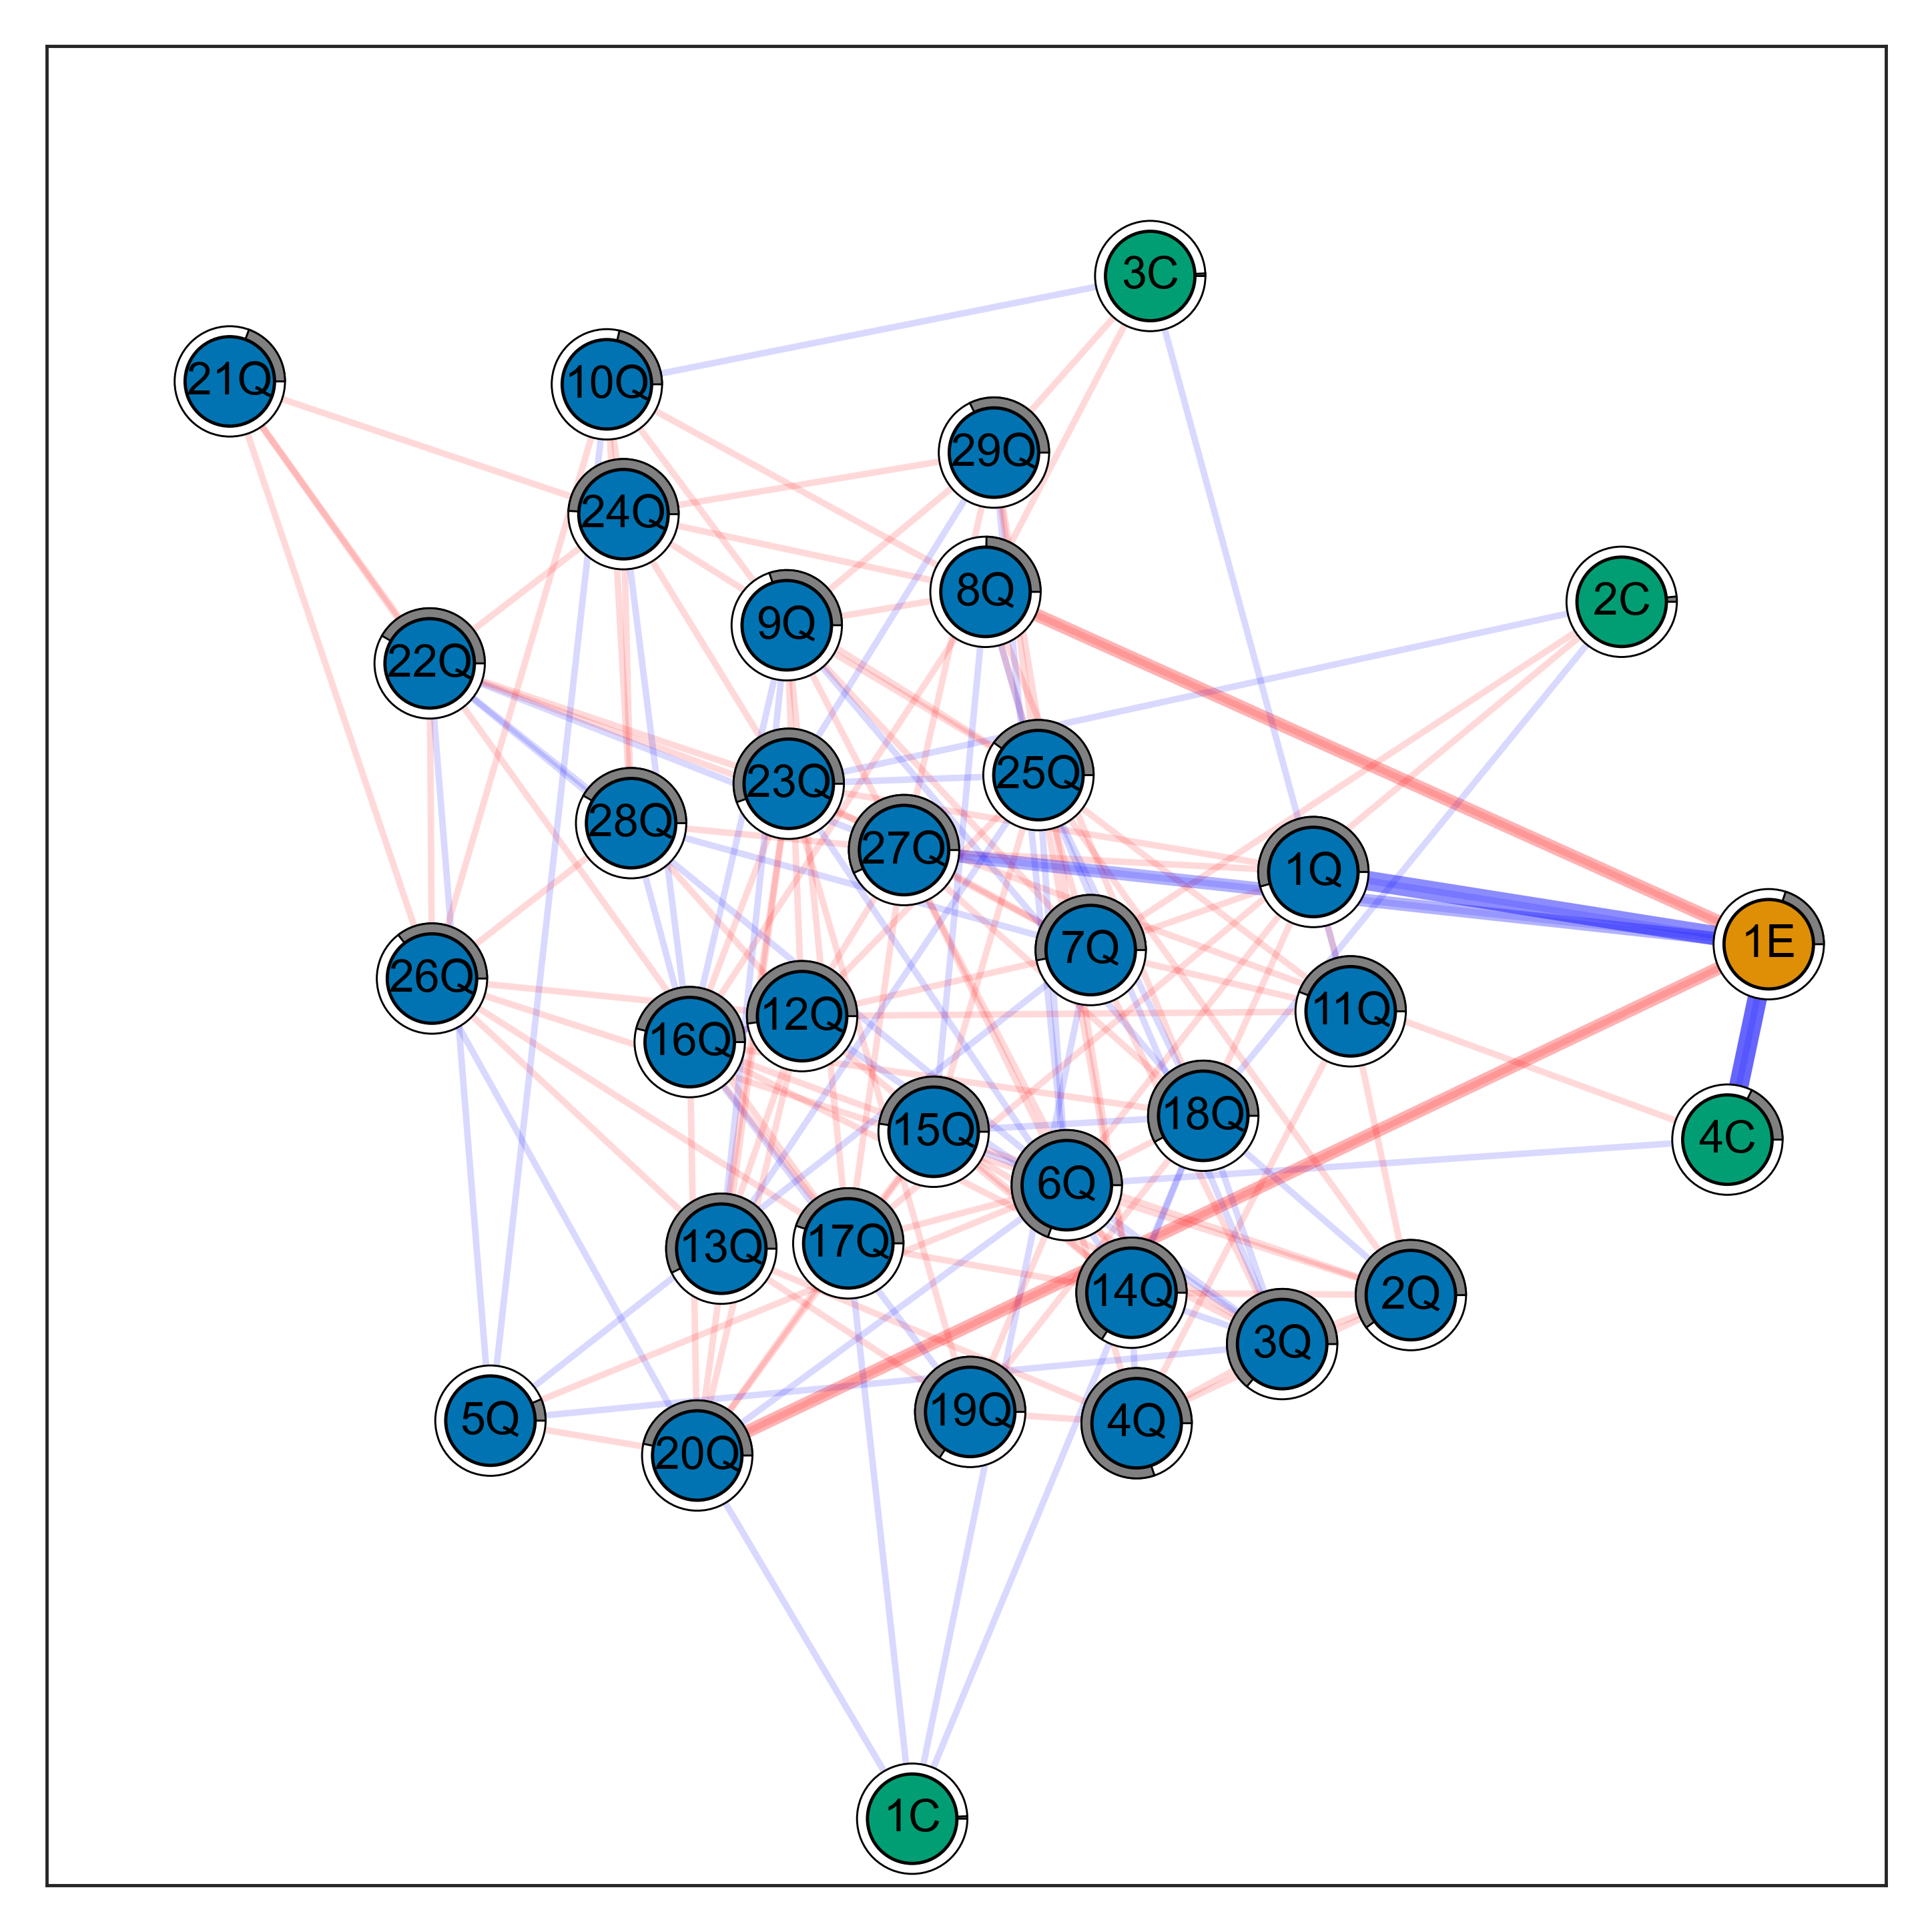

In [13]:
ern_cov_layout, ern_cov_G = utils.draw_graph(
    links[1], 
    seed=3, 
    basic_links=utils.leave_n_edges_from_eeg(links[1], N=0),
    basic='first', 
    nodes_predictabilities = out_of_sample_predictability[1], 
    specific_positions=positions,
    mapping=mapping, 
    save = 'ern_cov_net_test_pred_layout' if save_graphs else None
) 

Display predictability of nodes

In [16]:
with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
    display(within_sample_predictability[1])

with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
    display(out_of_sample_predictability[1])

e_ERN    e_LT_F       Age  Handness       RRQ  DASS-21 Stress  \
0  0.297613  0.283414  0.067939  0.058827  0.552296        0.579643   

   DASS-21 Dep    STAI-T  STAI-S Diff       BIS    BAS_D  BAS_PRZY   BAS_NAG  \
0     0.671764  0.779158      0.08745  0.635197  0.39476  0.488097  0.419247   

     OBSESS     HOARD       ORD    CHECK       OT      WBSI   INDEC_F  \
0  0.563633  0.279581  0.356297  0.29796  0.60826  0.465944  0.502746   

        PUN       REW      HARM      G_SE     T-CTR   OB_PERF        PS  \
0  0.646206  0.316156  0.267168  0.258326  0.400396  0.576716  0.436356   

        AMB      PRED     STAND     IUS-P     IUS-I      SES  performance  
0  0.487045  0.526643  0.364248  0.435896  0.512764  0.71932     0.054696

e_ERN    e_LT_F       Age  Handness       RRQ  DASS-21 Stress  \
0  0.200604  0.177385  0.007366  0.015512  0.542596        0.600152   

   DASS-21 Dep    STAI-T  STAI-S Diff       BIS     BAS_D  BAS_PRZY   BAS_NAG  \
0     0.639676  0.802467      0.06362  0.694415  0.476501  0.460315  0.448328   

     OBSESS     HOARD       ORD    CHECK        OT      WBSI   INDEC_F  \
0  0.530029  0.247118  0.301229  0.21328  0.554267  0.442483  0.578444   

       PUN       REW      HARM      G_SE     T-CTR   OB_PERF       PS  \
0  0.65625  0.465766  0.193607  0.354649  0.416591  0.490499  0.39996   

       AMB      PRED     STAND     IUS-P     IUS-I       SES  performance  
0  0.56792  0.416837  0.322132  0.521552  0.571823  0.659772      0.00765

Save graph

In [17]:
nx.write_gml(ern_cov_G, '../data/graphs/ern_cov_graph_test_pred_layout.gml')

#### ERN graph

In [20]:
# GENERATE THE COV GRAPH LAYOUT FIRST!
layout = ern_cov_layout.copy()

# remove covariates nodes from the layout
layout.pop('1C', None)
layout.pop('2C', None)
layout.pop('3C', None)
layout.pop('4C', None)

array([ 0.82766857, -0.18913916])

1E,1Q,0.194
1E,8Q,-0.03
1E,11Q,-0.023
1E,20Q,-0.034
1E,26Q,-0.027
1E,27Q,0.023
1E,29Q,0.025


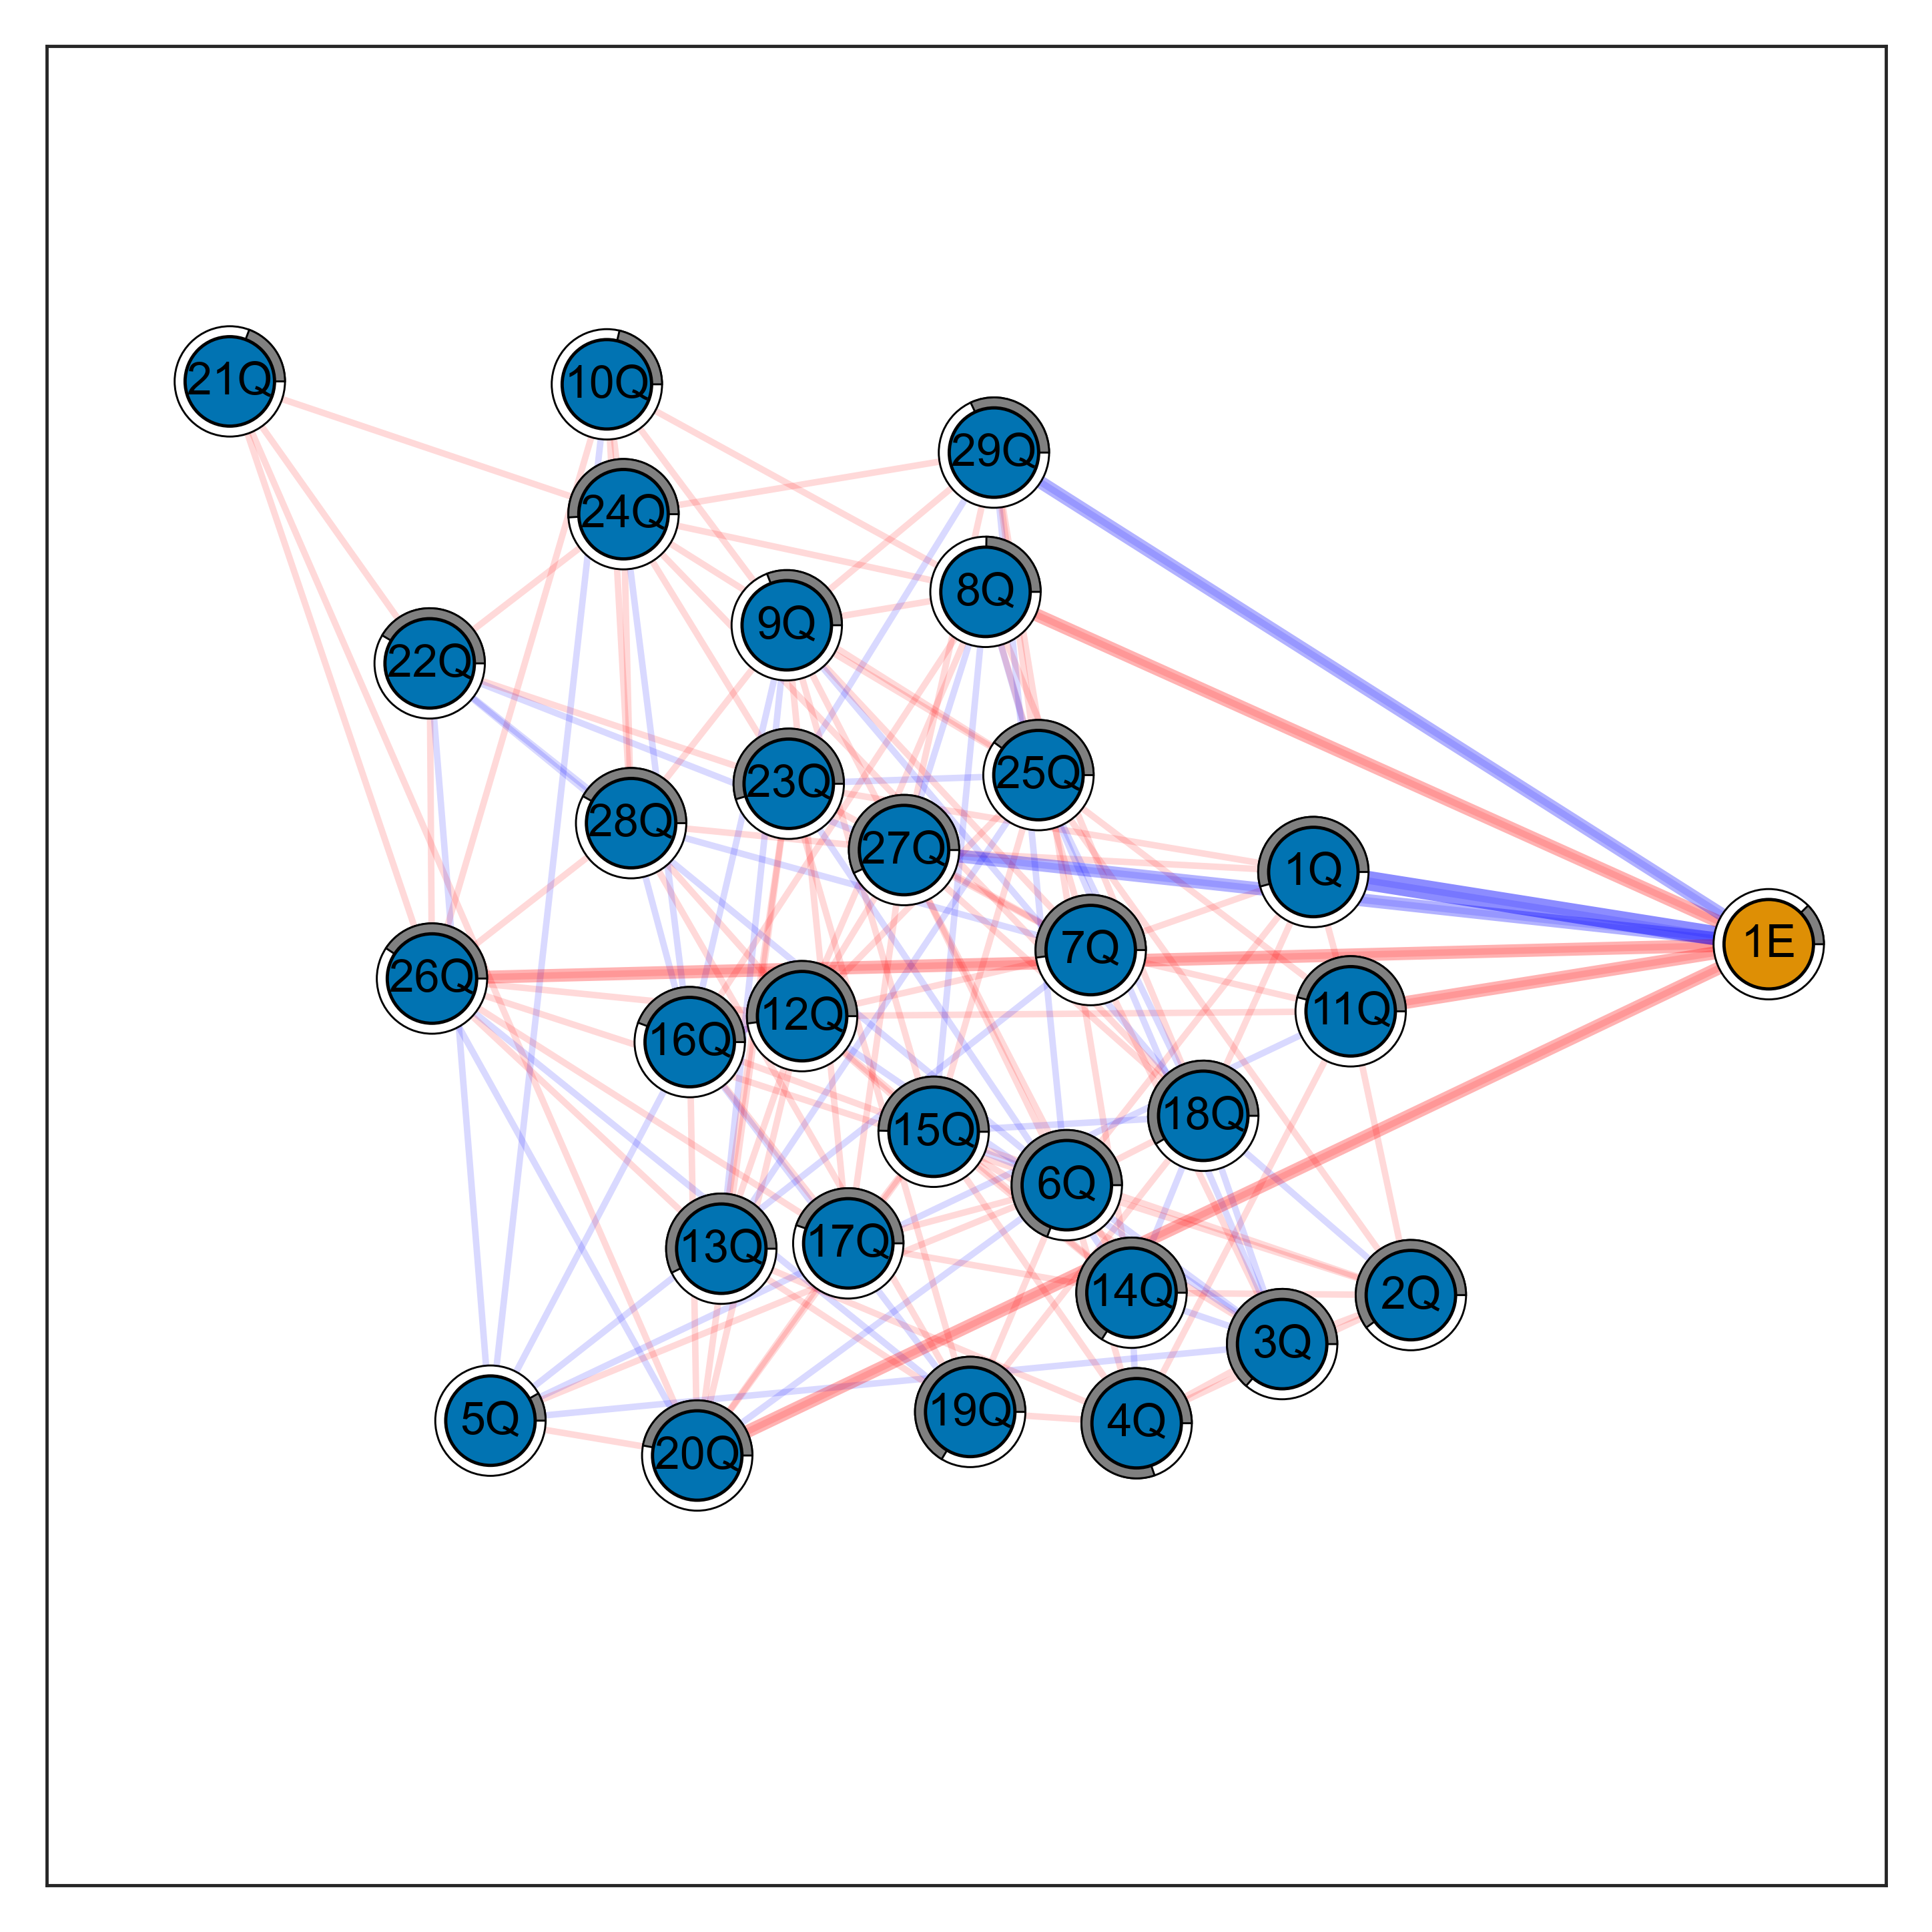

In [22]:
ern_layout, ern_G = utils.draw_graph(
    links[0], 
    seed=13, 
    basic_links=utils.leave_n_edges_from_eeg(links[0], N=0),
    basic='first', 
    nodes_predictabilities = out_of_sample_predictability[0], 
    mapping=mapping,     
    layout = layout,
    save='ern_net_test_pred_layout' if save_graphs else None
) 

Display the predictability of nodes

In [23]:
with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
    display(within_sample_predictability[0])

with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
    display(out_of_sample_predictability[0])

e_ERN       RRQ  DASS-21 Stress  DASS-21 Dep   STAI-T  STAI-S Diff  \
0  0.06739  0.552296        0.579643     0.671727  0.78109     0.093599   

        BIS    BAS_D  BAS_PRZY   BAS_NAG   OBSESS     HOARD       ORD  \
0  0.625591  0.41349  0.473137  0.413509  0.55208  0.288864  0.358292   

      CHECK        OT      WBSI   INDEC_F       PUN       REW     HARM  \
0  0.288755  0.598628  0.462183  0.496385  0.653142  0.311978  0.26703   

       G_SE     T-CTR   OB_PERF        PS       AMB      PRED     STAND  \
0  0.285453  0.390865  0.577982  0.433276  0.495466  0.530123  0.359533   

      IUS-P     IUS-I       SES  
0  0.437958  0.512764  0.718992

e_ERN       RRQ  DASS-21 Stress  DASS-21 Dep    STAI-T  STAI-S Diff  \
0  0.123536  0.542596        0.600152     0.636864  0.802756     0.082413   

       BIS     BAS_D  BAS_PRZY   BAS_NAG    OBSESS     HOARD       ORD  \
0  0.69208  0.496793  0.442821  0.446433  0.521994  0.247277  0.308312   

      CHECK        OT      WBSI   INDEC_F       PUN       REW      HARM  \
0  0.213276  0.545311  0.458758  0.585081  0.663564  0.471037  0.192762   

       G_SE     T-CTR   OB_PERF       PS       AMB      PRED     STAND  \
0  0.407194  0.415157  0.509348  0.39879  0.568186  0.418777  0.319347   

      IUS-P     IUS-I       SES  
0  0.521279  0.571823  0.659709

Save graph

In [24]:
nx.write_gml(ern_G, '../data/graphs/ern_graph_new_layout_test_predictability.gml')

#### CRN graph

In [25]:
crn_layout = ern_layout.copy()
# assing the position of ERN from the layout to the CRN
crn_layout['2E'] = crn_layout['1E']

# remove ERN node from the layout
crn_layout.pop('1E', None)

array([0.87261727, 0.02336634])

2E,15Q,0.153
2E,16Q,-0.148
2E,8Q,-0.051
2E,24Q,0.163
2E,12Q,-0.021


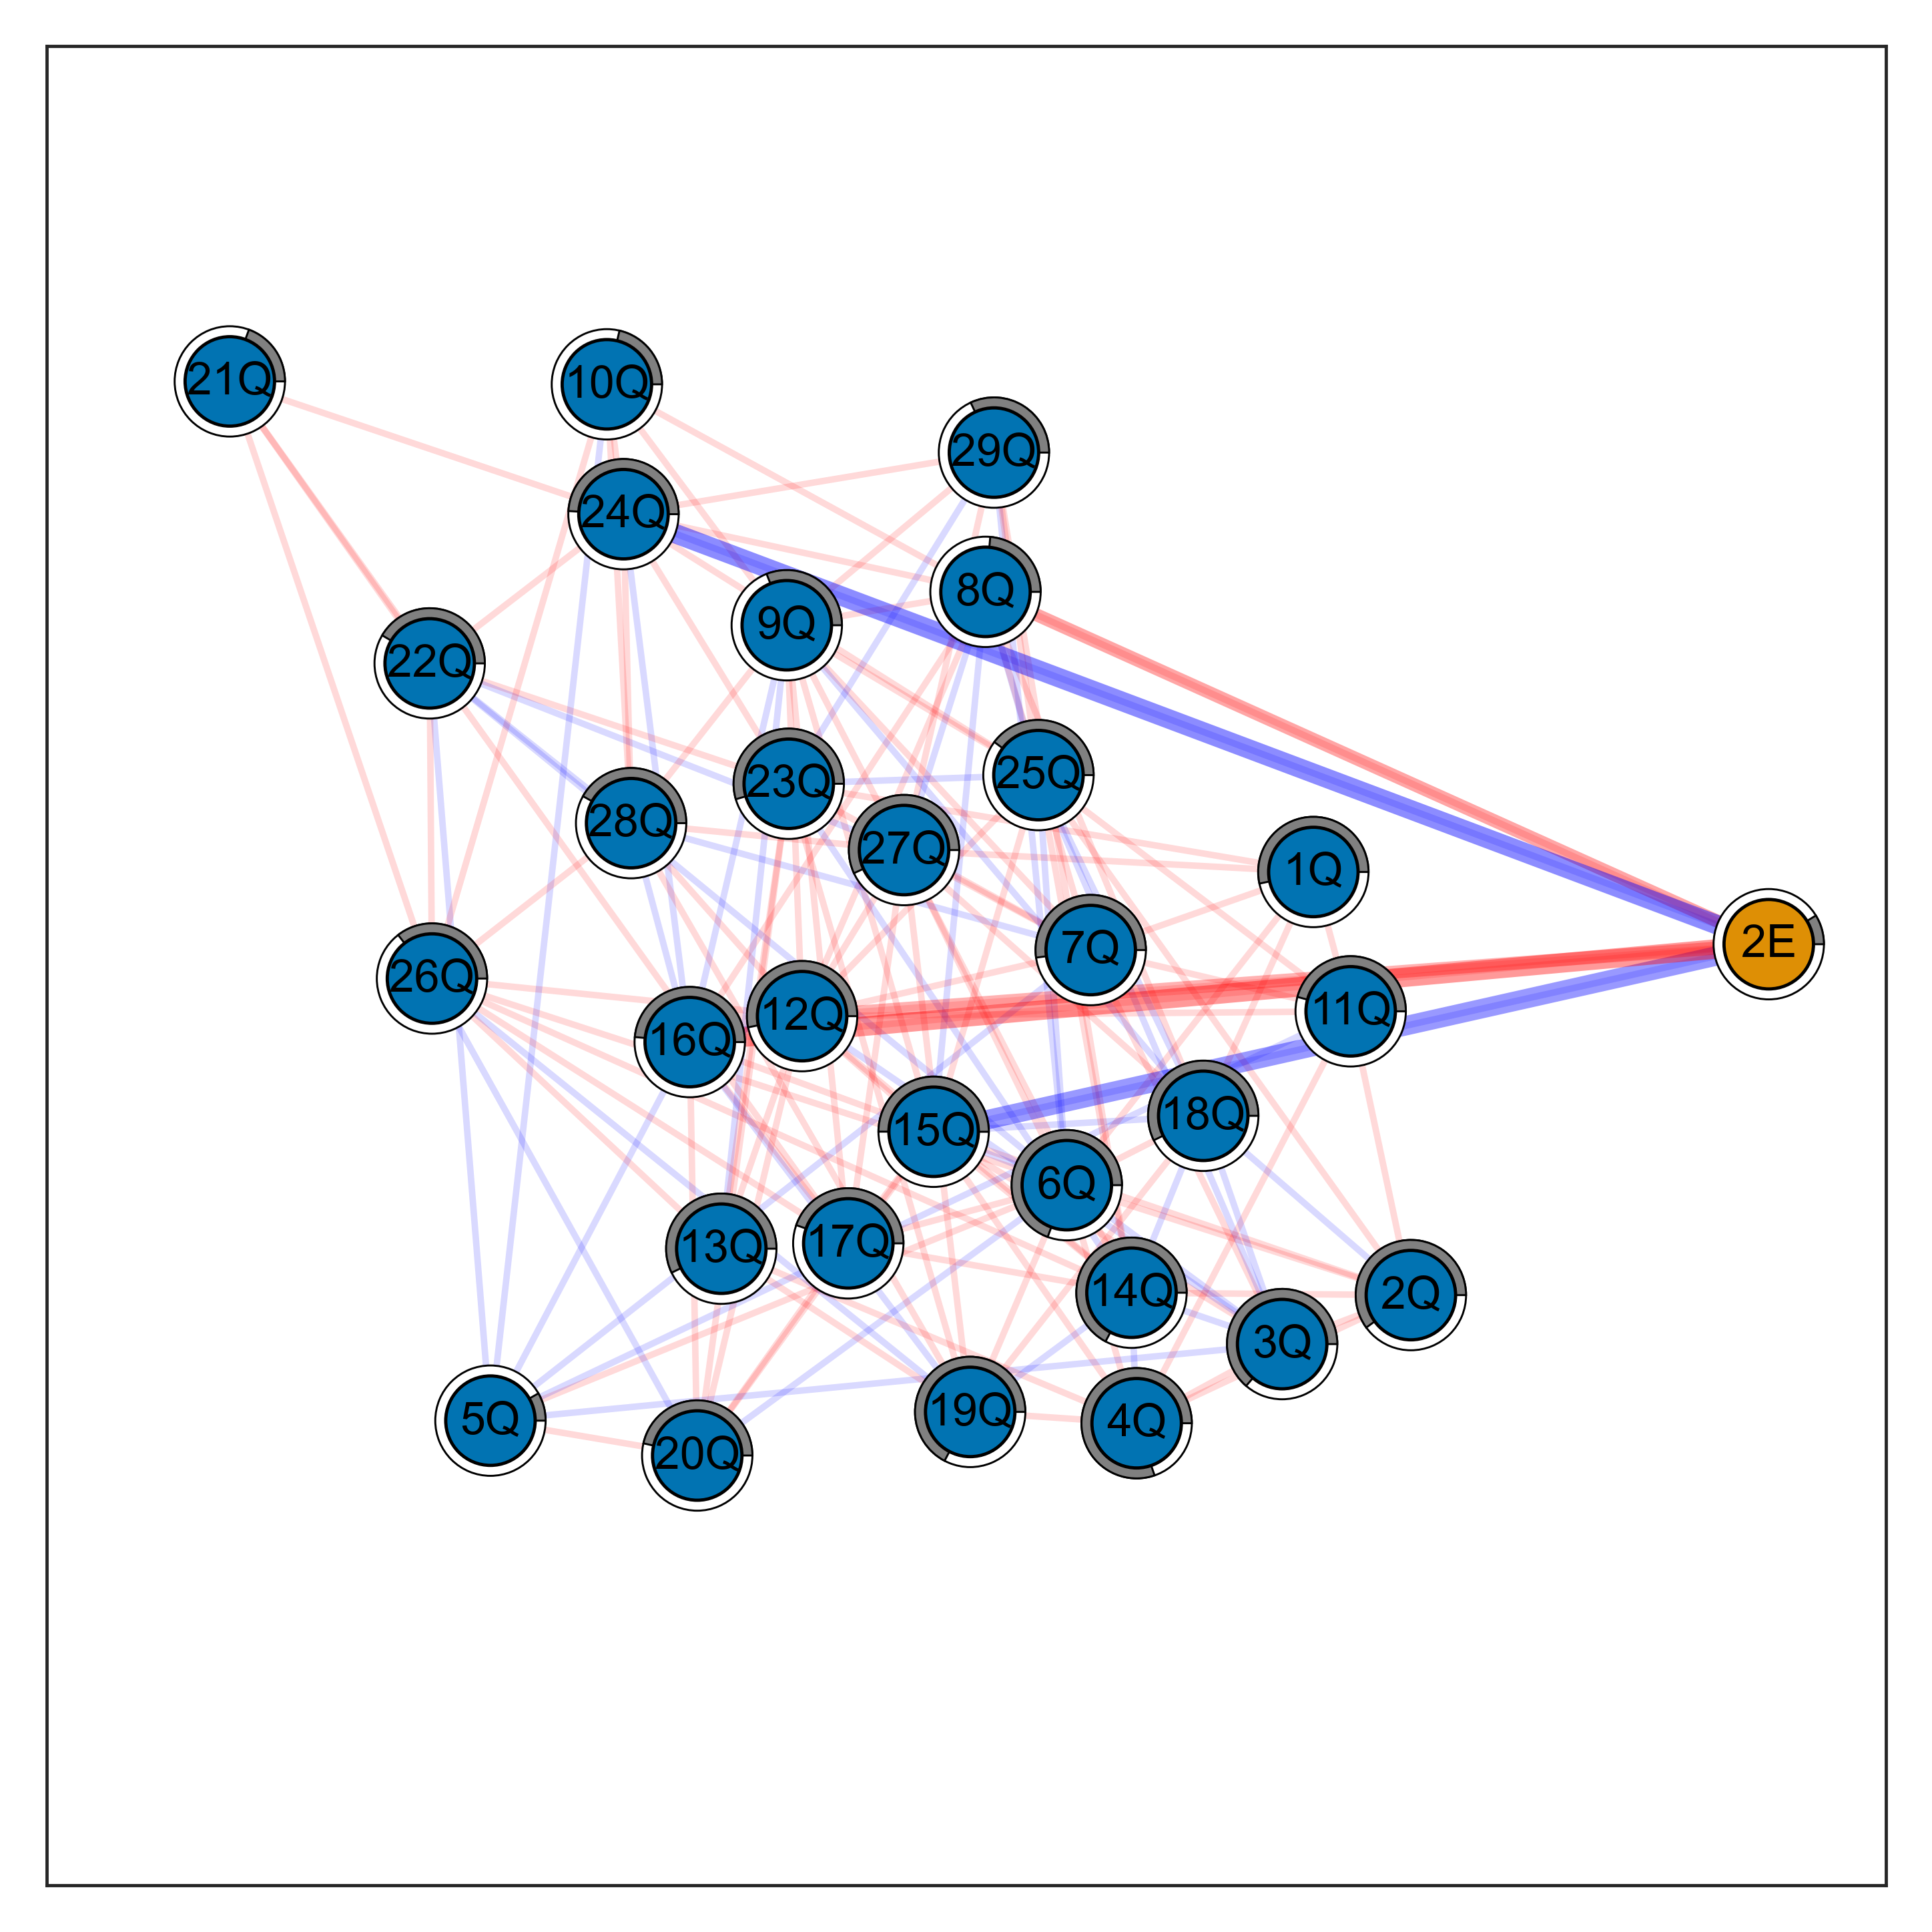

In [26]:
_, crn_G = utils.draw_graph(
    links[2], 
    seed=16, 
    basic_links=utils.leave_n_edges_from_eeg(links[2], N=0), 
    basic='first', 
    mapping=mapping, 
    nodes_predictabilities = out_of_sample_predictability[2],
    specific_positions=positions,
    layout=crn_layout,
    save = 'crn_net_test_pos_layout' if save_graphs else None
) 

Display predictability

In [27]:
with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
    display(within_sample_predictability[2])

with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
    display(out_of_sample_predictability[2])

e_CRN       RRQ  DASS-21 Stress  DASS-21 Dep   STAI-T  STAI-S Diff  \
0  0.0609  0.541908        0.579643     0.671727  0.78109     0.093599   

        BIS     BAS_D  BAS_PRZY   BAS_NAG   OBSESS     HOARD     ORD  \
0  0.627077  0.418601  0.479535  0.413931  0.55208  0.290157  0.3629   

      CHECK        OT      WBSI  INDEC_F       PUN     REW      HARM  \
0  0.288755  0.598628  0.456921  0.48813  0.653581  0.3028  0.267168   

       G_SE     T-CTR   OB_PERF        PS       AMB      PRED     STAND  \
0  0.278857  0.390865  0.582525  0.433208  0.494506  0.530123  0.356786   

      IUS-P     IUS-I       SES  
0  0.443591  0.511032  0.720408

e_CRN       RRQ  DASS-21 Stress  DASS-21 Dep    STAI-T  STAI-S Diff  \
0  0.087056  0.533795        0.600152     0.636864  0.802756     0.082413   

        BIS     BAS_D  BAS_PRZY   BAS_NAG    OBSESS     HOARD       ORD  \
0  0.693747  0.499635  0.485461  0.446439  0.521994  0.236265  0.309665   

      CHECK        OT      WBSI   INDEC_F       PUN       REW      HARM  \
0  0.213276  0.545311  0.457936  0.573208  0.673251  0.464578  0.193607   

       G_SE     T-CTR   OB_PERF        PS       AMB      PRED     STAND  \
0  0.355118  0.415157  0.490968  0.397574  0.568888  0.418777  0.319292   

      IUS-P     IUS-I       SES  
0  0.532605  0.571637  0.672166

Save graph

In [28]:
nx.write_gml(crn_G, '../data/graphs/crn_graph_test_pred_layout.gml')

#### CRN cov graph

In [29]:
crn_cov_layout = ern_cov_layout.copy()

# assing the position of ERN from the layout to the CRN
crn_cov_layout['2E'] = crn_cov_layout['1E']

# remove ERN node from the layout
crn_cov_layout.pop('1E', None)

array([0.87261727, 0.02336634])

2E,4C,0.436
2E,15Q,0.039
2E,16Q,-0.053
2E,8Q,-0.026
2E,24Q,0.066
2E,25Q,0.02


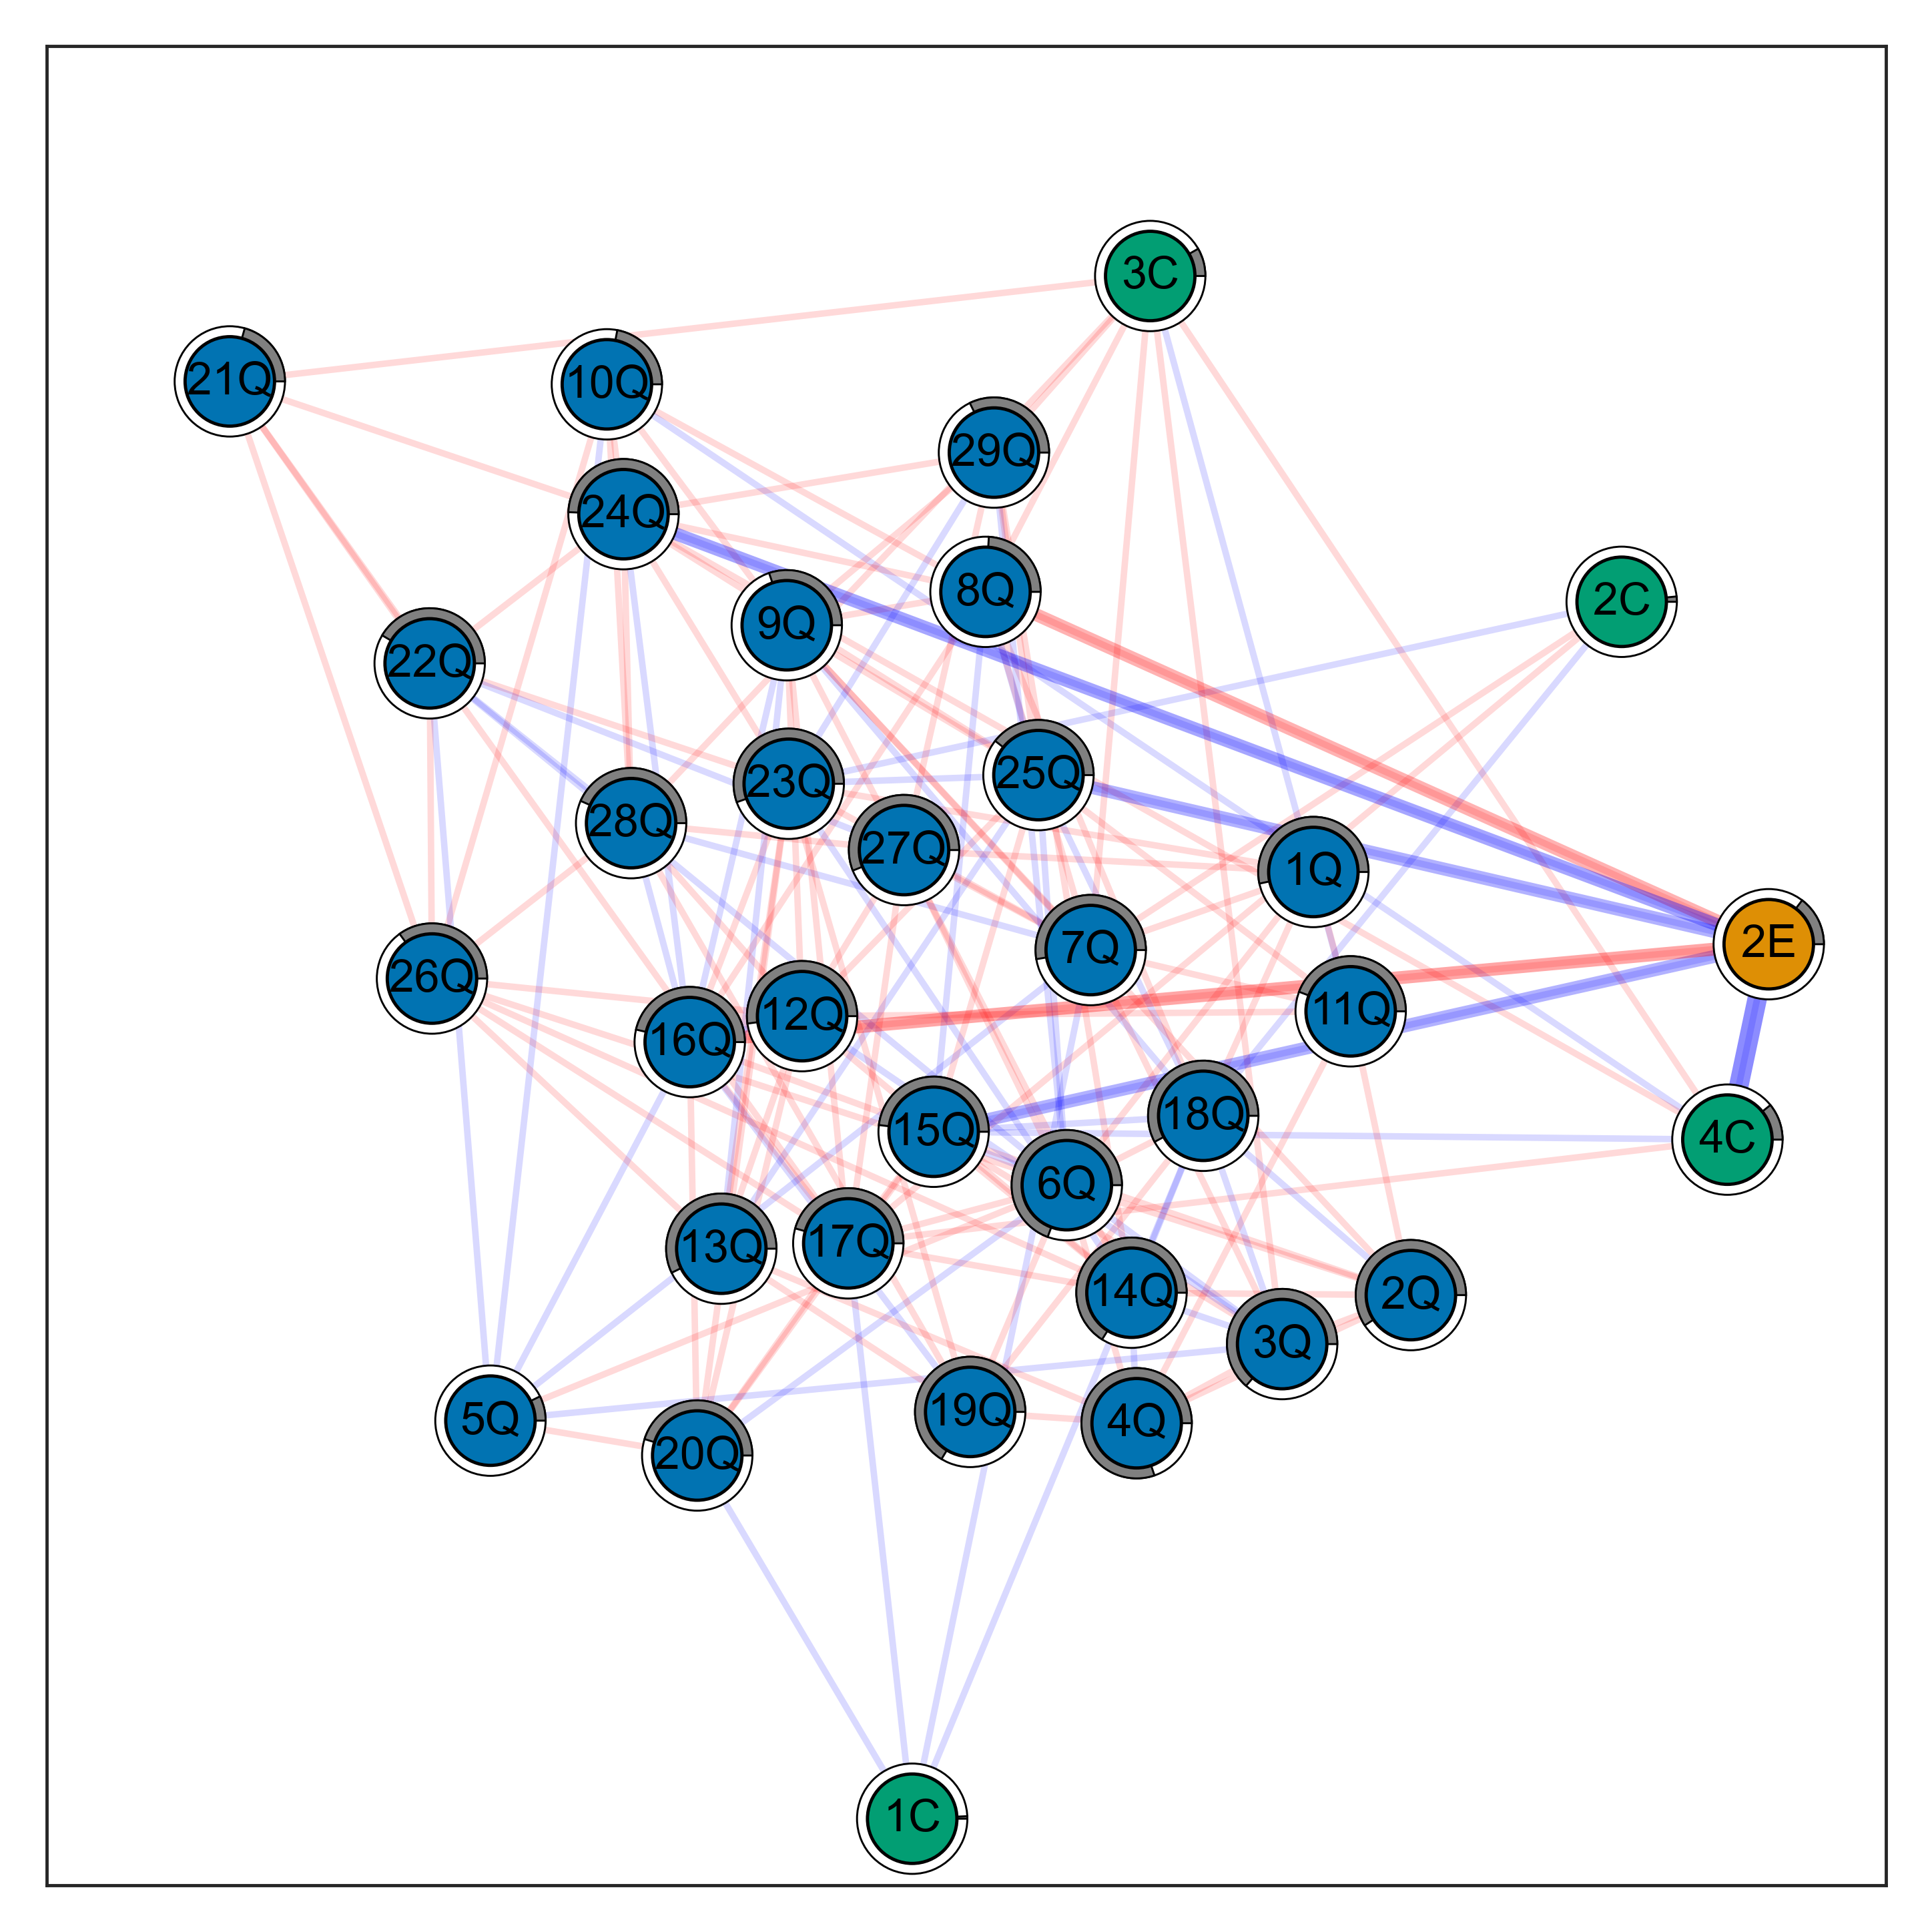

In [30]:
_, crn_cov_G = utils.draw_graph(
    links[3], 
    seed=8, 
    basic_links=utils.leave_n_edges_from_eeg(links[3], N=0), 
    basic='first', 
    mapping=mapping,
    nodes_predictabilities = out_of_sample_predictability[3],
    specific_positions = positions,
    layout = crn_cov_layout,
    save = 'crn_cov_net_test_pred_layout' if save_graphs else None
) 

Display predictability of nodes

In [31]:
with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
    display(within_sample_predictability[3])

with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
    display(out_of_sample_predictability[3])

e_CRN  e_LT_F2_C       Age  Handness       RRQ  DASS-21 Stress  \
0  0.183273   0.213325  0.067939  0.058827  0.541908        0.576316   

   DASS-21 Dep    STAI-T  STAI-S Diff       BIS     BAS_D  BAS_PRZY   BAS_NAG  \
0     0.673284  0.779158     0.091887  0.627077  0.407234  0.484897  0.444706   

     OBSESS     HOARD       ORD     CHECK       OT      WBSI   INDEC_F  \
0  0.566578  0.279413  0.359532  0.301502  0.60826  0.465944  0.492019   

        PUN       REW     HARM      G_SE     T-CTR   OB_PERF       PS  \
0  0.648324  0.298648  0.27473  0.250893  0.390865  0.585095  0.42457   

        AMB      PRED     STAND     IUS-P     IUS-I       SES  performance  
0  0.481019  0.536242  0.364248  0.435896  0.512764  0.719585     0.076855

e_CRN  e_LT_F2_C       Age  Handness       RRQ  DASS-21 Stress  \
0  0.146604   0.107871  0.007366  0.015512  0.533795        0.592512   

   DASS-21 Dep    STAI-T  STAI-S Diff       BIS     BAS_D  BAS_PRZY   BAS_NAG  \
0     0.636573  0.802467     0.072556  0.693747  0.480509  0.463546  0.456323   

     OBSESS     HOARD       ORD     CHECK        OT      WBSI   INDEC_F  \
0  0.526386  0.240321  0.302011  0.219706  0.554267  0.442483  0.578327   

        PUN       REW      HARM      G_SE     T-CTR   OB_PERF        PS  \
0  0.663054  0.451875  0.206363  0.349906  0.415157  0.494209  0.393538   

        AMB      PRED     STAND     IUS-P     IUS-I      SES  performance  
0  0.560708  0.433967  0.322132  0.521552  0.571823  0.66062     0.082309

Save graph

In [32]:
nx.write_gml(crn_cov_G, '../data/graphs/crn_cov_graph_test_pred_layout.gml')

## Visualize ERN and CRN graphs difference

Define node labels mappers

In [33]:
mapping_difference_graphs = {
    "RRQ": "1Q",
    "DASS-21 Stress": "2Q",
    "DASS-21 Dep": "3Q",
    "STAI-T": "4Q",
    "STAI-S Diff": '5Q',
    "BIS": "6Q",
    "OBSESS": "7Q",
    "HOARD": "8Q",
    "ORD": "9Q",
    "CHECK": "10Q",
    "WBSI": "11Q",
    "IUS-P": "12Q",
    "IUS-I": "13Q",
    "SES": "14Q",
    'BAS_D': "15Q",
    'BAS_PRZY': "16Q",
    'BAS_NAG': "17Q",
    'INDEC_F': "18Q",
    'PUN': "19Q",
    'REW': "20Q",
    'HARM': "21Q",
    'T-CTR': "22Q",
    "OT": "23Q",
    'OB_PERF': "24Q",
    'PS': "25Q",
    'G_SE': "26Q",
    'AMB': "27Q",
    'PRED': "28Q",
    'STAND': "29Q",   
    "Age": "1C",
    "Handness": "2C",
    'e_ERN': "1E",
    'e_LT_F': "4C",
    'performance': "3C",
    'e_CRN': "1E",
    'e_LT_F2_C': "4C",
}

# mapping_crn = {
#     "RRQ": "1Q",
#     "DASS-21 Stress": "2Q",
#     "DASS-21 Dep": "3Q",
#     "STAI-T": "4Q",
#     "STAI-S Diff": '5Q',
#     "BIS": "6Q",
#     "OBSESS": "7Q",
#     "HOARD": "8Q",
#     "ORD": "9Q",
#     "CHECK": "10Q",
#     "WBSI": "11Q",
#     "IUS-P": "12Q",
#     "IUS-I": "13Q",
#     "SES": "14Q",
#     'BAS_D': "15Q",
#     'BAS_PRZY': "16Q",
#     'BAS_NAG': "17Q",
#     'INDEC_F': "18Q",
#     'PUN': "19Q",
#     'REW': "20Q",
#     'HARM': "21Q",
#     'T-CTR': "22Q",
#     "OT": "23Q",
#     'OB_PERF': "24Q",
#     'PS': "25Q",
#     'G_SE': "26Q",
#     'AMB': "27Q",
#     'PRED': "28Q",
#     'STAND': "29Q",   
#     "Age": "1C",
#     "Handness": "2C",
#     'e_CRN': "1E",
#     'e_LT_F2_C': "4C",
#     'performance': "3C",
# }

### Create graphs from precision matrices

Here, the threshold is set very low so as not to introduce an artificial qualitative difference between ERN and CRN networks when the link is slightly below the threshold in one network (and will be zeroed) and slightly above in the second (and will not be zeroed).

In [34]:
def create_graph(links, mapping):
    G = nx.from_pandas_edgelist(links,'var1','var2', edge_attr='weight', create_using=nx.Graph())
    G = nx.relabel_nodes(G, mapping)
    return G

In [35]:
links_for_diffs = [utils.leave_n_edges_from_eeg(utils.get_links(matrix_, threshold=0.005), N=2) for matrix_ in precision_matrixes]
graphs_for_diffs = [create_graph(links, mapping_difference_graphs) for links in links_for_diffs]

### Estimate difference graphs

#### 1. ERN minus CRN model

1E,8Q,-0.03 enlarged/dropped red
1E,10Q,-0.02 unique ERN but too low
1E,22Q,0.013 unique ERN but too low
8Q,25Q,0.04 enlarged/dropped blue
20Q,26Q,0.158 enlarged/dropped blue
26Q,22Q,-0.15 enlarged/dropped red
26Q,17Q,-0.181 enlarged/dropped red
26Q,21Q,-0.113 enlarged/dropped red
26Q,14Q,-0.005 enlarged/dropped red
6Q,17Q,-0.32 enlarged/dropped red
6Q,25Q,0.018 enlarged/dropped blue
15Q,18Q,0.077 enlarged/dropped blue
15Q,16Q,-0.382 enlarged/dropped red
17Q,21Q,-0.013 enlarged/dropped red
21Q,14Q,-0.014 unique ERN but too low
18Q,14Q,0.485 enlarged/dropped blue
18Q,9Q,0.033 enlarged/dropped blue
18Q,19Q,-0.491 enlarged/dropped red
18Q,25Q,0.209 enlarged/dropped blue
4Q,14Q,1.569 enlarged/dropped blue
4Q,9Q,0.009 unique ERN but too low
4Q,19Q,-1.047 enlarged/dropped red
9Q,14Q,-0.108 enlarged/dropped red
9Q,13Q,0.072 enlarged/dropped blue


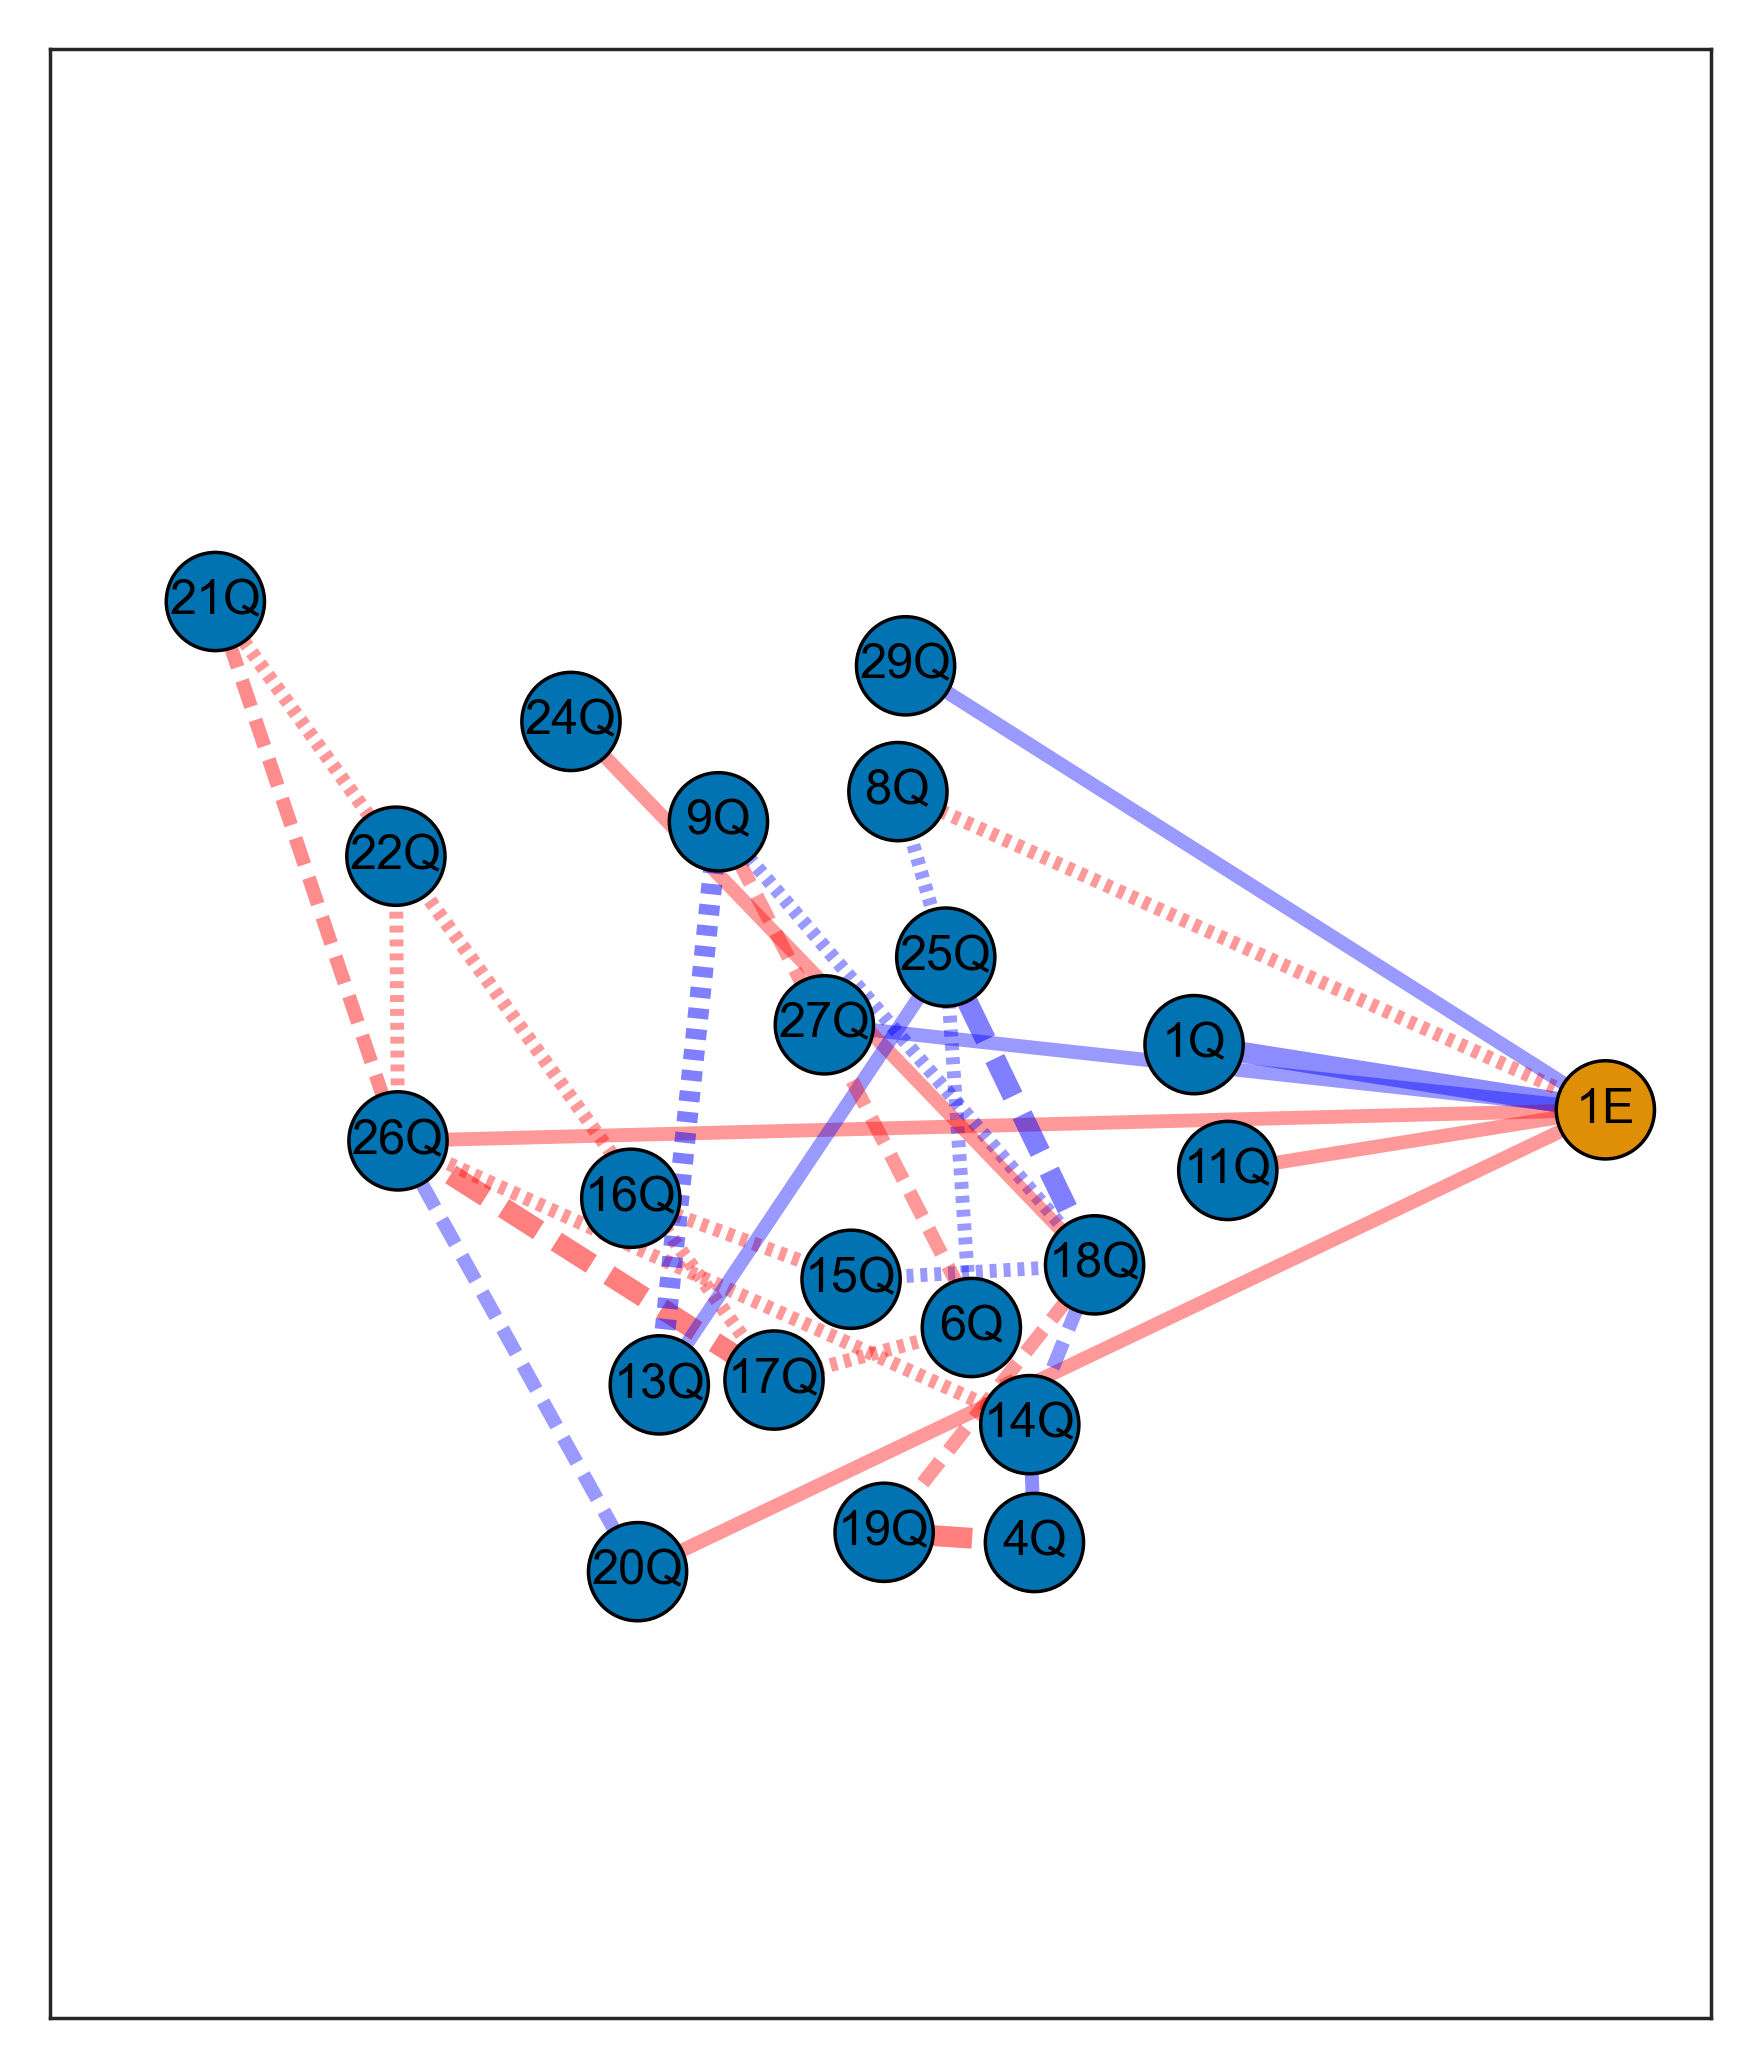

In [36]:
difference_graph_ern, colors, styles = utils.estimate_difference_graph(
    graphs_for_diffs[0], 
    graphs_for_diffs[2],
    threshold=0.02
)

utils.draw_difference_graph(
    difference_graph_ern, 
    colors=colors, 
    linestyle=styles, 
    seed=16, 
    no_purple=True, 
    scale=1.2,
    layout = ern_layout,
    save = 'ern_crn_diff_layout' if save_graphs else None
)

Calculate nodes predictability

In [37]:
G_ = difference_graph_ern.copy()       
ern_crn_diff_matrix = nx.to_numpy_array(G_)
ern_crn_diff_matrix_df = pd.DataFrame(ern_crn_diff_matrix, columns=G_.nodes(), index=G_.nodes())

In [40]:
ern_crn_diff_within_sample_predictability = utils.calculate_nodes_predictability(train_datasets[0].rename(columns=mapping_difference_graphs), ern_crn_diff_matrix_df)

with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
    display(ern_crn_diff_within_sample_predictability)

ern_crn_diff_out_of_sample_predictability = utils.calculate_nodes_predictability(test_datasets[0].rename(columns=mapping_difference_graphs), ern_crn_diff_matrix_df)

with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
    display(ern_crn_diff_out_of_sample_predictability)

1E        1Q        8Q       11Q       20Q      26Q       22Q  \
0  0.06739  0.030042  0.002897  0.000405  0.023883  0.13408  0.062762   

        27Q       29Q        6Q       15Q       16Q       17Q       21Q  \
0  0.015771  0.008445  0.000932  0.199009  0.147104  0.017891  0.057032   

        18Q       4Q       25Q       24Q       19Q        9Q       14Q  \
0  0.415916  0.69839  0.018435  0.075104  0.582884  0.007965  0.625507   

       13Q  
0  0.00268

1E        1Q        8Q      11Q       20Q      26Q       22Q  \
0  0.123536  0.004023  0.035643  0.00039  0.003044  0.27762  0.043246   

       27Q       29Q        6Q       15Q       16Q      17Q       21Q  \
0  0.01711  0.000011  0.050102  0.169927  0.079743  0.05457  0.075847   

        18Q       4Q      25Q       24Q       19Q        9Q       14Q  \
0  0.474705  0.66279  0.09196  0.095572  0.572359  0.030946  0.588171   

        13Q  
0  0.031391

Save the graph

In [41]:
nx.write_gml(difference_graph_ern, '../data/graphs/ern_crn_diff_graph_layout.gml')
ern_crn_diff_matrix_df.to_pickle(f'../data/precision_matrixes/{dataset}/precision_matrix_ern_crn_diff_layout.pkl')

#### ERN with covariates minus CRN with covariates

1E,4C,0.697 enlarged/dropped blue
1E,10Q,-0.014 unique ERN but too low
1E,29Q,0.005 unique ERN but too low
1E,3C,0.015 unique ERN but too low
4C,12Q,-0.011 unique ERN but too low
1Q,6Q,-0.368 enlarged/dropped red
8Q,3C,-0.116 enlarged/dropped red
8Q,29Q,0.006 unique ERN but too low
20Q,26Q,0.051 enlarged/dropped blue
3C,11Q,0.044 enlarged/dropped blue
3C,14Q,-0.006 unique ERN but too low
6Q,25Q,0.102 enlarged/dropped blue
6Q,15Q,0.081 enlarged/dropped blue
15Q,2Q,-0.044 enlarged/dropped red
16Q,19Q,0.252 enlarged/dropped blue
17Q,26Q,-0.147 enlarged/dropped red
11Q,25Q,-0.18 enlarged/dropped red
11Q,2Q,-0.279 enlarged/dropped red
25Q,2Q,-0.178 enlarged/dropped red


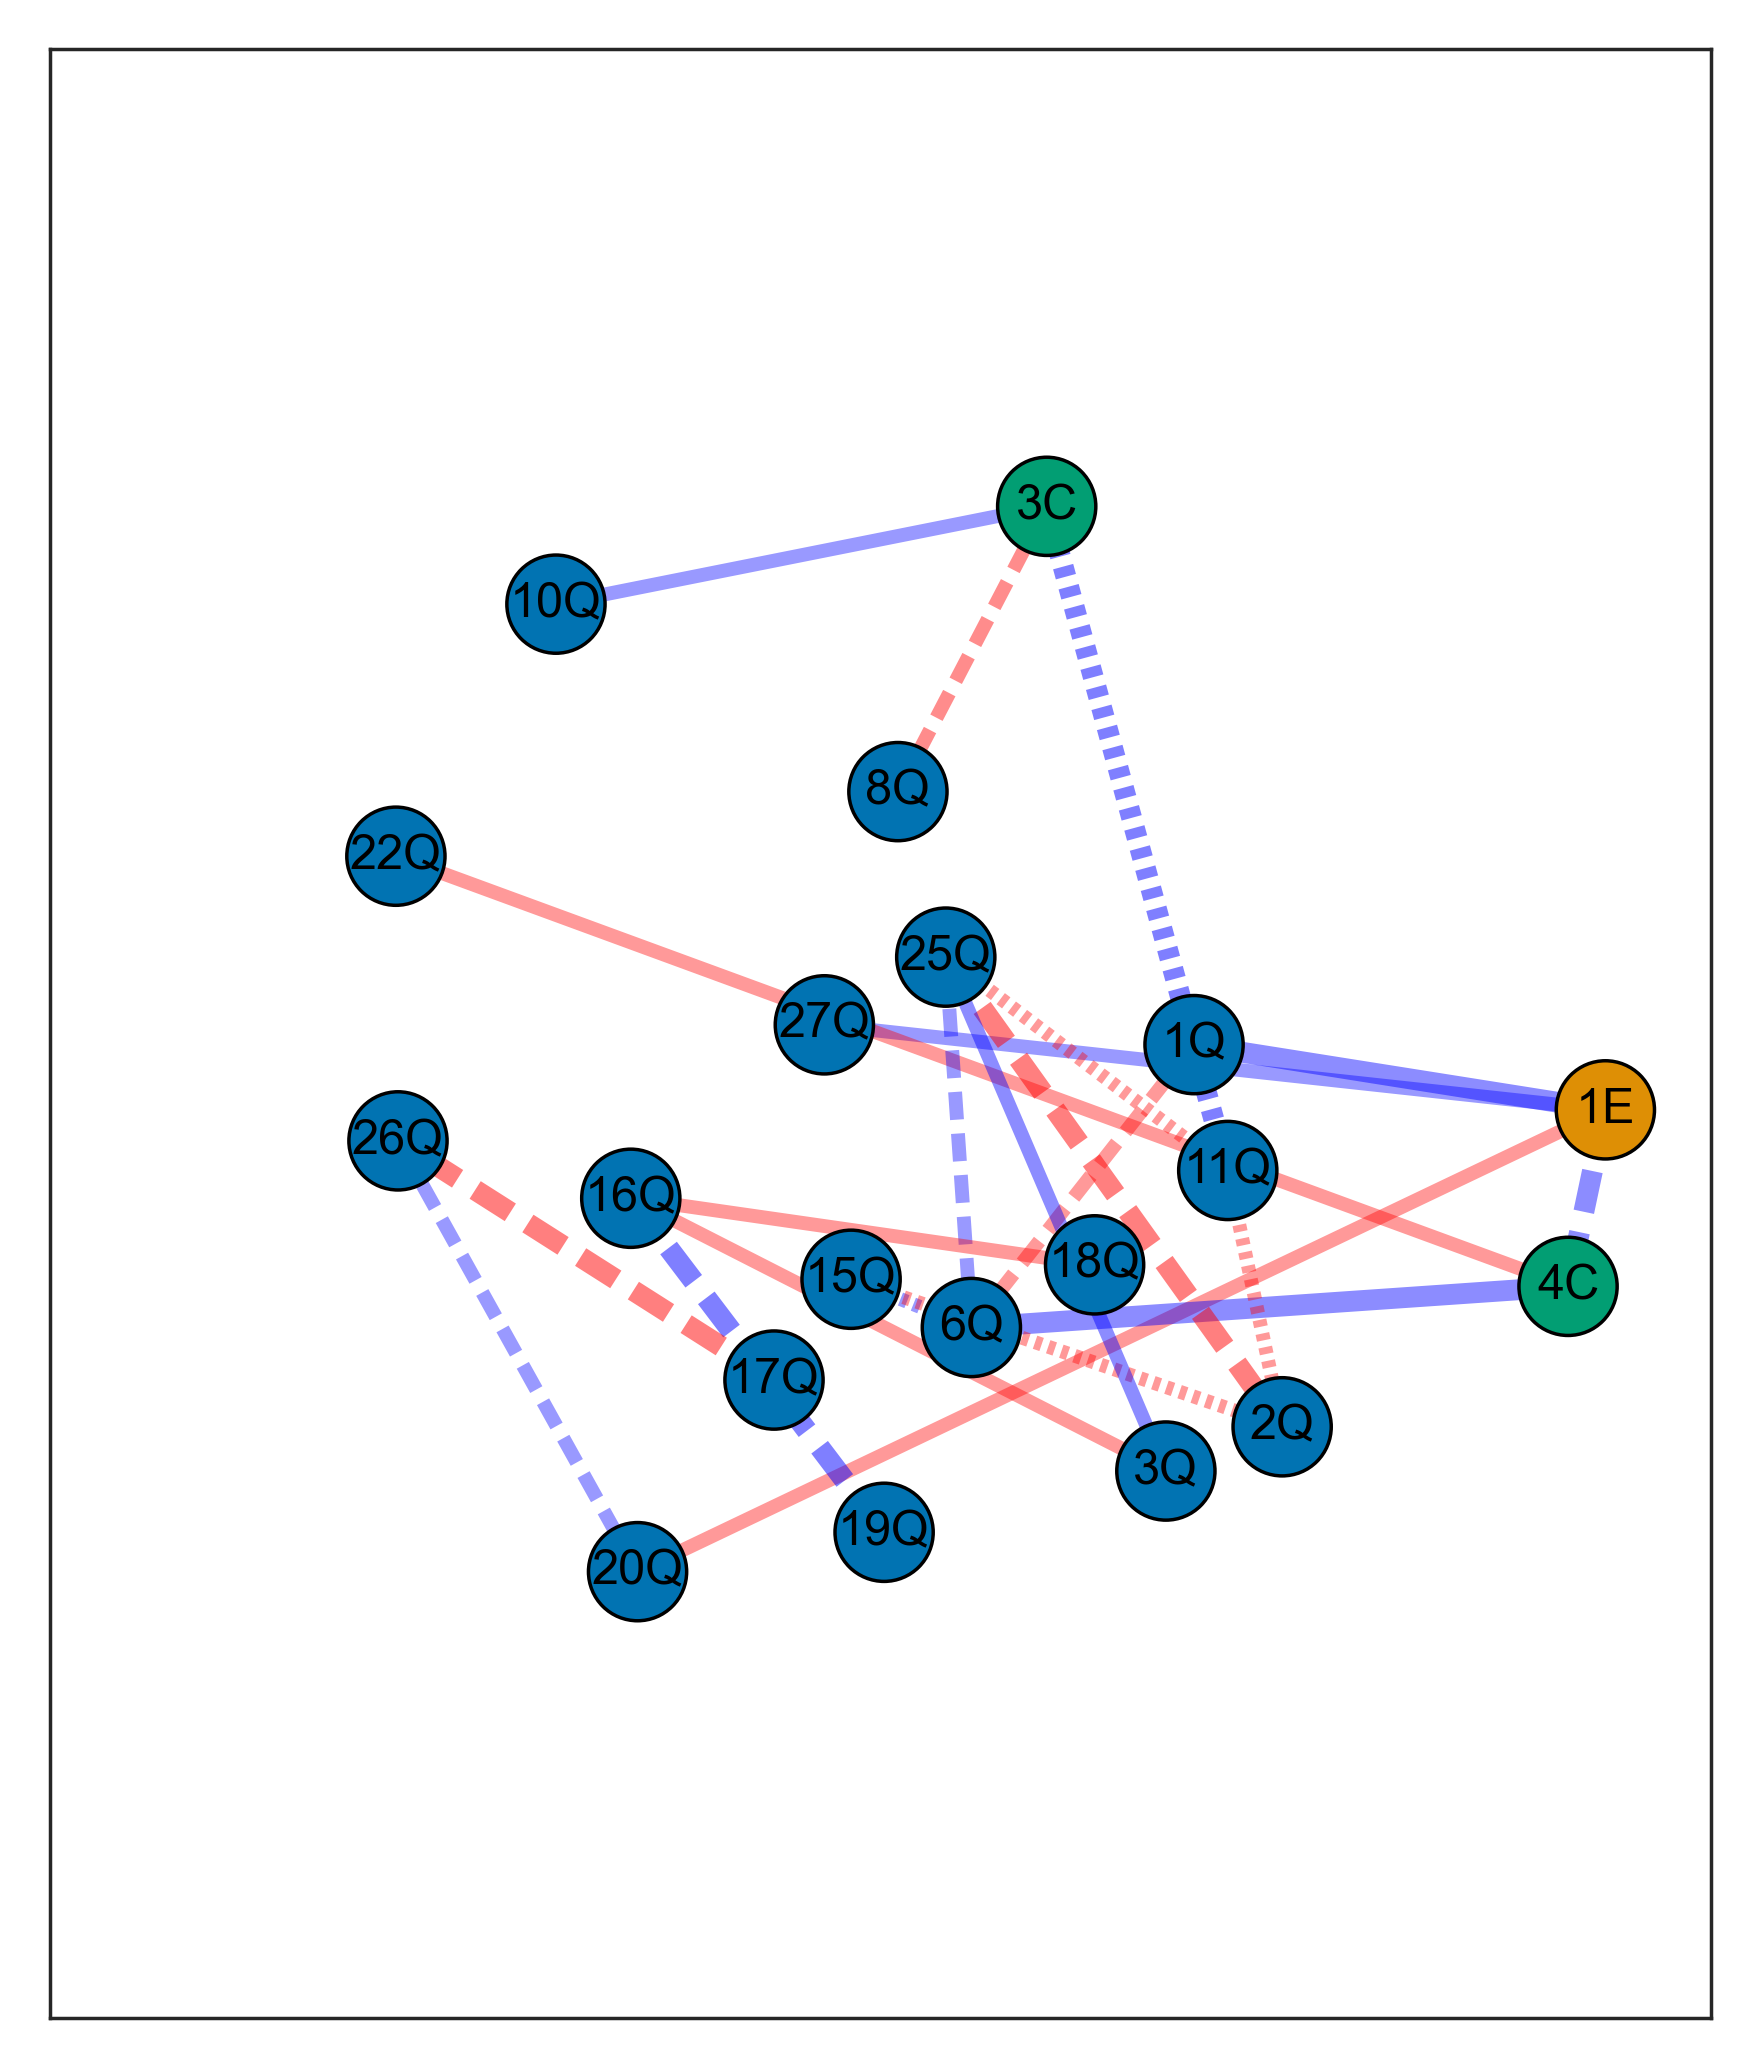

In [43]:
difference_graph_ern_cov, colors, styles = utils.estimate_difference_graph(
    graphs_for_diffs[1], 
    graphs_for_diffs[3],
    threshold=0.02
)

utils.draw_difference_graph(
    difference_graph_ern_cov, 
    colors=colors, 
    linestyle=styles, 
    seed=7, 
    no_purple=True,
    scale=1.3,
    layout = ern_cov_layout,
    save = 'ern_crn_cov_diff_layout' if save_graphs else None
)

Calculate nodes predictability

In [44]:
G_ = difference_graph_ern_cov.copy()       
ern_crn_cov_diff_matrix = nx.to_numpy_array(G_)
ern_crn_cov_diff_matrix_df = pd.DataFrame(ern_crn_cov_diff_matrix, columns=G_.nodes(), index=G_.nodes())

In [46]:
ern_crn_cov_diff_within_sample_predictability = utils.calculate_nodes_predictability(train_datasets[1].rename(columns=mapping_difference_graphs), ern_crn_cov_diff_matrix_df)

with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
    display(ern_crn_cov_diff_within_sample_predictability)

ern_crn_cov_diff_out_of_sample_predictability = utils.calculate_nodes_predictability(test_datasets[1].rename(columns=mapping_difference_graphs), ern_crn_cov_diff_matrix_df)

with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
    display(ern_crn_cov_diff_out_of_sample_predictability)

1E        4C        1Q       8Q      10Q       20Q       27Q  \
0  0.291565  0.283414  0.292888  0.01251  0.00095  0.023883  0.015771   

         3C        6Q       15Q       16Q       17Q       26Q       11Q  \
0  0.023491  0.334528  0.080184  0.102009  0.009333  0.037997  0.255216   

       18Q       22Q       25Q        3Q        2Q       19Q  
0  0.01308  0.006172  0.100309  0.006145  0.236909  0.091375

1E        4C        1Q        8Q      10Q       20Q      27Q  \
0  0.197644  0.177385  0.310545  0.004967  0.00002  0.003044  0.01711   

         3C        6Q       15Q       16Q       17Q      26Q       11Q  \
0  0.005676  0.372842  0.133502  0.035813  0.045036  0.06344  0.245664   

        18Q       22Q       25Q        3Q        2Q       19Q  
0  0.012611  0.001162  0.059068  0.022923  0.250665  0.033883

Save the graph

In [47]:
nx.write_gml(difference_graph_ern_cov, '../data/graphs/ern_crn_cov_diff_graph_layout.gml')
ern_crn_cov_diff_matrix_df.to_pickle(f'../data/precision_matrixes/{dataset}/precision_matrix_ern_crn_cov_diff_layout.pkl')

---
## Draw legend

- ERN

In [4]:
legend_labels = {
    "1Q: Rumination": "1Q",
    "2Q: Stress": "2Q",
    "3Q: Depression": "3Q",
    "4Q: Anxiety trait": "4Q",
    "5Q: Affective load": '5Q',
    "6Q: Behavioral inhibition": "6Q",
    "7Q: Obsessing": "7Q",
    "8Q: Hoarding": "8Q",
    "9Q: Ordering": "9Q",
    "10Q: Checking": "10Q",
    "11Q: Thought supression": "11Q",
    "12Q: Prospective intolerance of uncertainty": "12Q",
    "13Q: Inhibitory intolerance of uncertainty": "13Q",
    "14Q: Self-esteem": "14Q",
    '15Q: Drive': "15Q",
    '16Q: Fun-seeking': "16Q",
    '17Q: Reward responsiveness': "17Q",
    '18Q: Indecisivness': "18Q",
    '19Q: Punishment sensitivity': "19Q",
    '20Q: Reward sensitivity': "20Q",
    '21Q: Inflated harm responsibility': "21Q",
    '22Q: Importance of thought control': "22Q",
    "23Q: Threat overestimation": "23Q",
    '24Q: Perfectionism/intolerance of uncertainty': "24Q",
    '25Q: Personal standards': "25Q",
    '26Q: Guilt sensitivity': "26Q",
    '27Q: Avoidance of ambiguity': "27Q",
    '28Q: Need for predictability': "28Q",
    '29Q: High standards': "29Q",   
    "1C: Age": "1C",
    "2C: Handedness": "2C",
    '3C: Performance': "3C",
    '4C: ERN latency': "4C",
    '1E: ERN amplitude': "1E",
    # '2E: CRN': "2E",
}

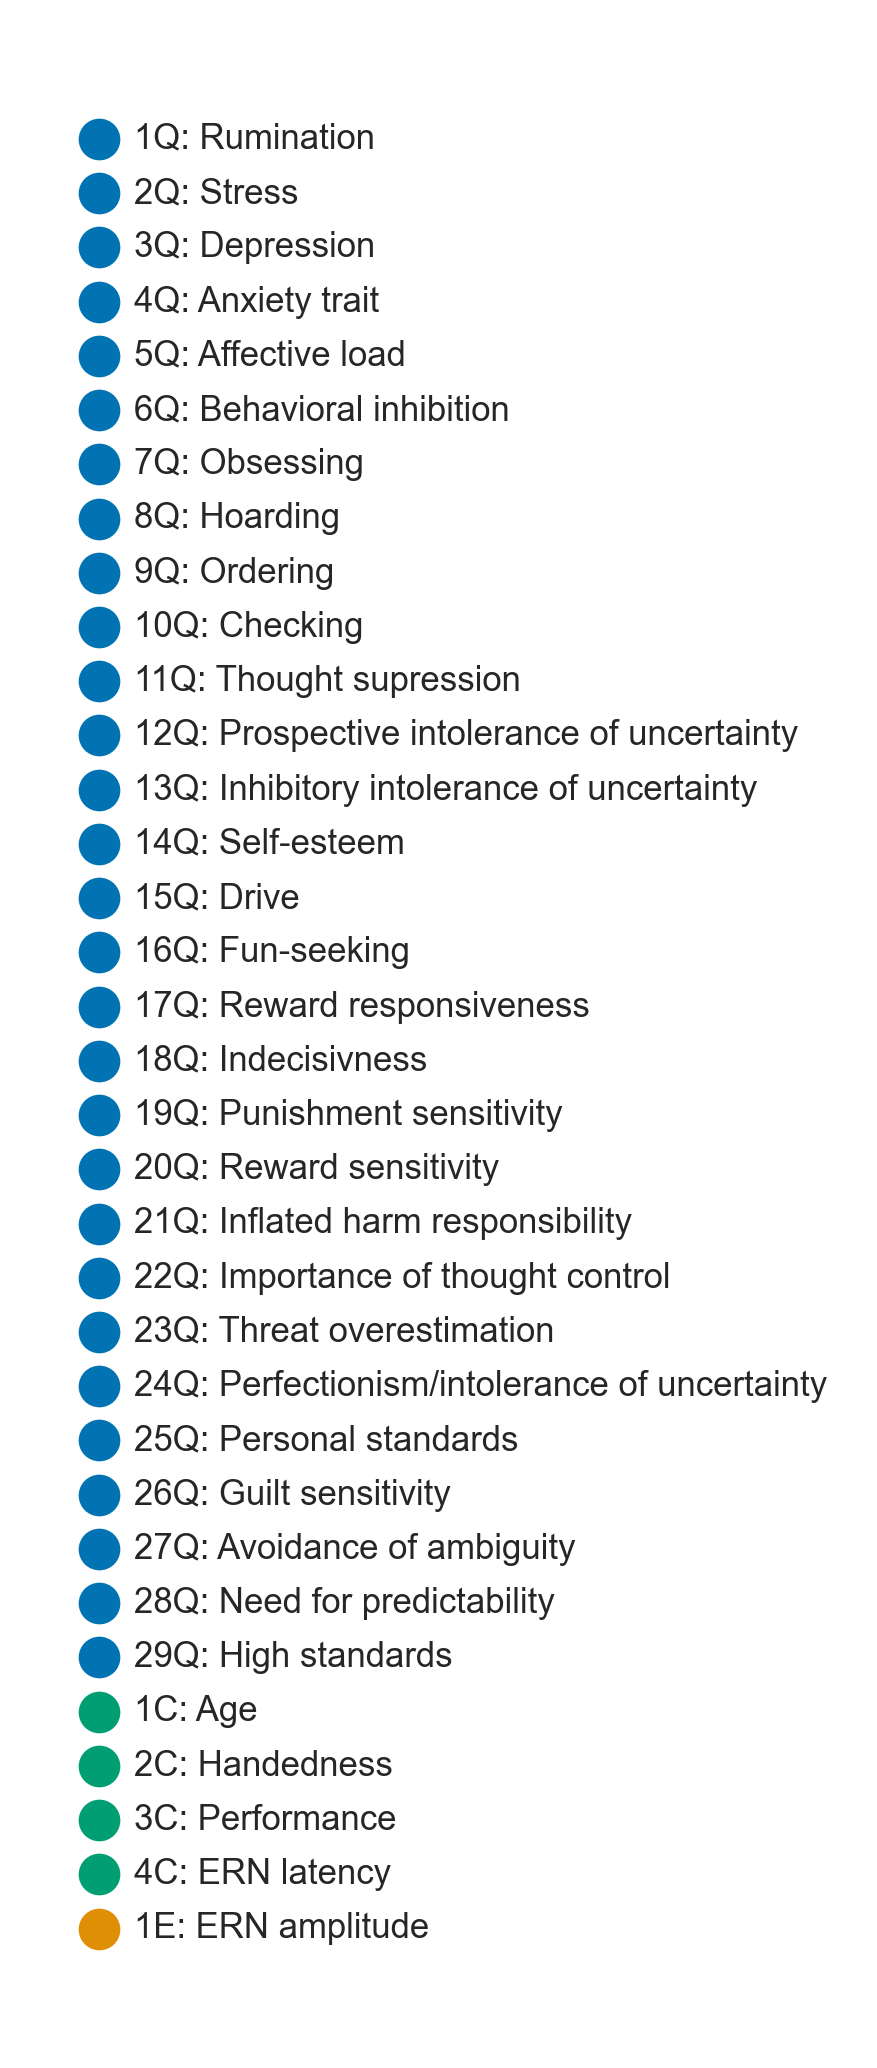

In [6]:
cm = 1/2.54
dpi = 500

plt.rcParams['figure.dpi'] = dpi
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['axes.labelsize'] = 6
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 0.5
sns.set_style("white")


palette = sns.color_palette("colorblind")

fig = plt.figure(3, figsize=(10*cm, 10*cm))
ax = fig.add_axes([0,0,1,1], aspect=1)
ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
# ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
    
# # change default range so that new circles will work
# ax.set_xlim((0, 10))
# ax.set_ylim((0, 10))
# some data
x = [0.5]*len(legend_labels)
y = np.linspace(0,1,len(legend_labels))

nodes_color=[palette[0] if item[1].find('Q') != -1 
                else palette[1]if item[1].find('E') != -1 
                else palette[2] for item in legend_labels.items()]


    
# ax.plot(x, y, 'o', color=nodes_color,  markersize=4)

for i, item in enumerate(legend_labels.items()):
    item_index = len(legend_labels) - i - 1
    
    ax.plot(
        x[item_index],
        y[item_index], 
        'o', 
        markersize=5,
        color=nodes_color[i],
    )
    
    plt.annotate(
        item[0],                       # label text
        (x[item_index], y[item_index]),                    # (x, y)
        textcoords="offset points",   
        xytext=(5, -1.35),               # (x, y) offset amount
        ha='left',
        fontsize=5
    )
    
plt.show()

fig.savefig('../images/ern_legend.png')

- CRN

In [7]:
legend_labels = {
    "1Q: Rumination": "1Q",
    "2Q: Stress": "2Q",
    "3Q: Depression": "3Q",
    "4Q: Anxiety trait": "4Q",
    "5Q: Affective load": '5Q',
    "6Q: Behavioral inhibition": "6Q",
    "7Q: Obsessing": "7Q",
    "8Q: Hoarding": "8Q",
    "9Q: Ordering": "9Q",
    "10Q: Checking": "10Q",
    "11Q: Thought supression": "11Q",
    "12Q: Prospective intolerance of uncertainty": "12Q",
    "13Q: Inhibitory intolerance of uncertainty": "13Q",
    "14Q: Self-esteem": "14Q",
    '15Q: Drive': "15Q",
    '16Q: Fun-seeking': "16Q",
    '17Q: Reward responsiveness': "17Q",
    '18Q: Indecisivness': "18Q",
    '19Q: Punishment sensitivity': "19Q",
    '20Q: Reward sensitivity': "20Q",
    '21Q: Inflated harm responsibility': "21Q",
    '22Q: Importance of thought control': "22Q",
    "23Q: Threat overestimation": "23Q",
    '24Q: Perfectionism/intolerance of uncertainty': "24Q",
    '25Q: Personal standards': "25Q",
    '26Q: Guilt sensitivity': "26Q",
    '27Q: Avoidance of ambiguity': "27Q",
    '28Q: Need for predictability': "28Q",
    '29Q: High standards': "29Q",   
    "1C: Age": "1C",
    "2C: Handedness": "2C",
    '3C: Performance': "3C",
    '4C: CRN latency': "4C",
    '2E: CRN amplitude': "1E",
    # '2E: CRN': "2E",
}

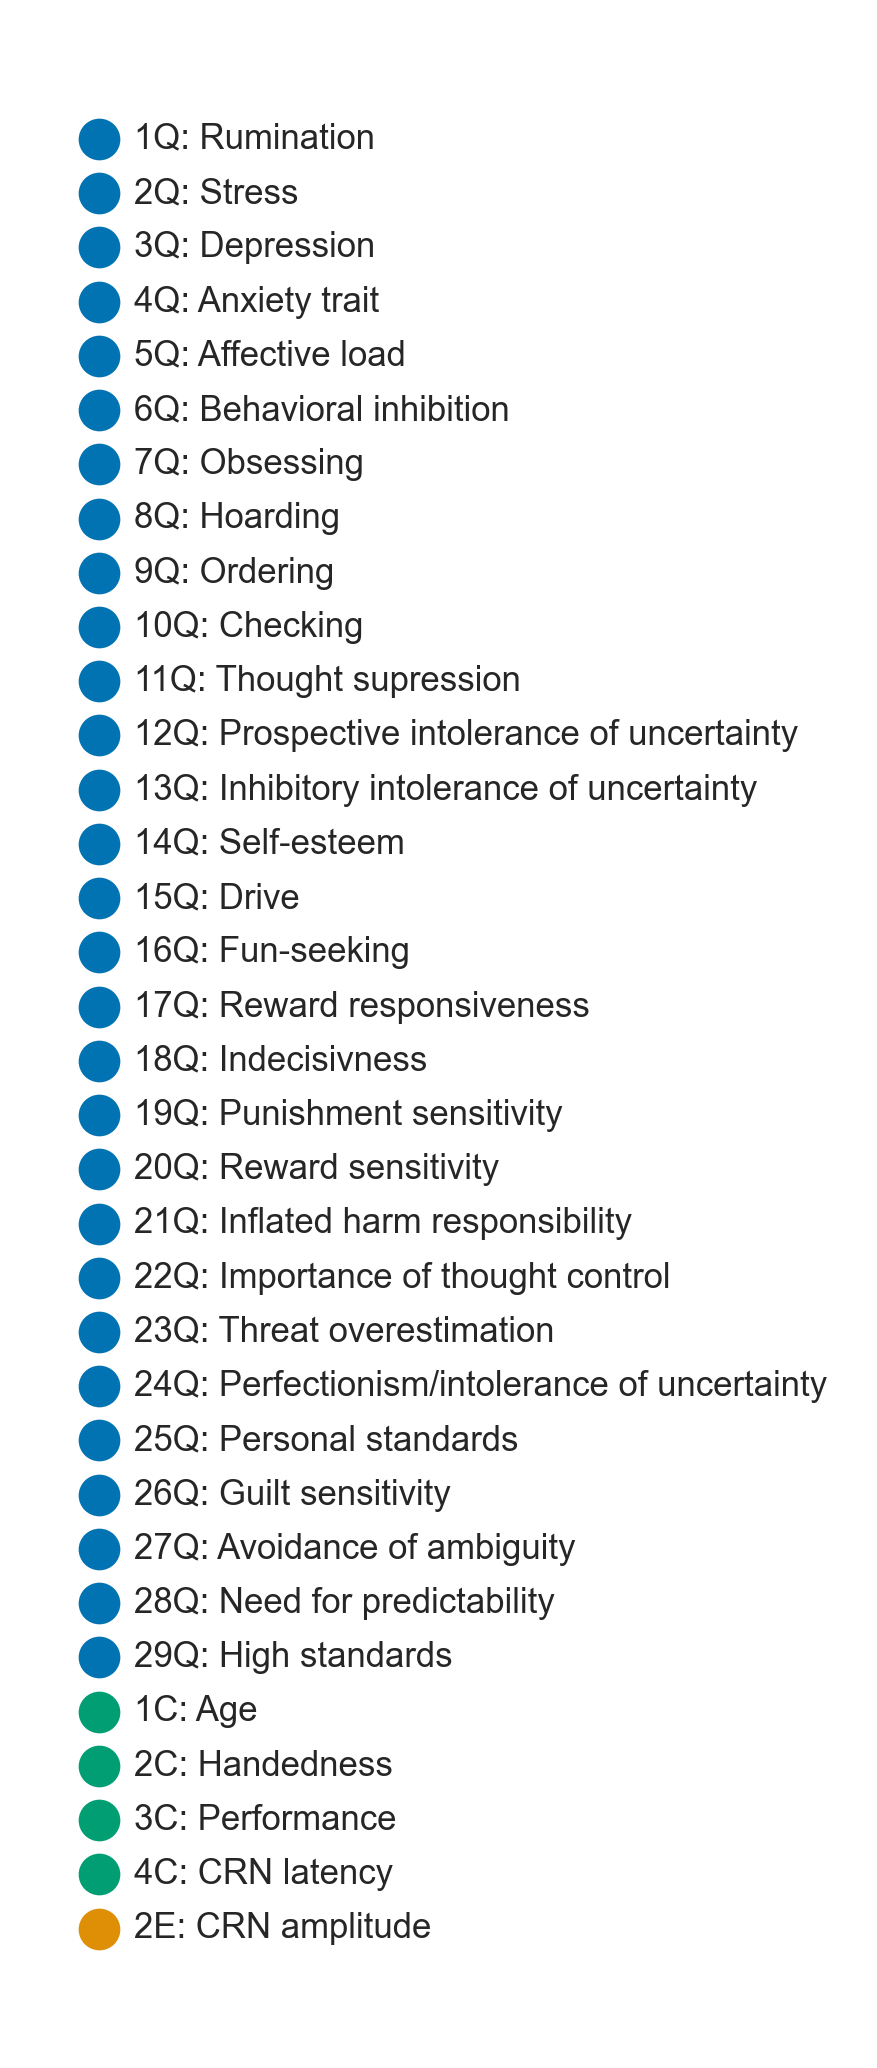

In [8]:
cm = 1/2.54
dpi = 500

plt.rcParams['figure.dpi'] = dpi
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['axes.labelsize'] = 6
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 0.5
sns.set_style("white")


palette = sns.color_palette("colorblind")

fig = plt.figure(3, figsize=(10*cm, 10*cm))
ax = fig.add_axes([0,0,1,1], aspect=1)
ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
# ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
    
# # change default range so that new circles will work
# ax.set_xlim((0, 10))
# ax.set_ylim((0, 10))
# some data
x = [0.5]*len(legend_labels)
y = np.linspace(0,1,len(legend_labels))

nodes_color=[palette[0] if item[1].find('Q') != -1 
                else palette[1]if item[1].find('E') != -1 
                else palette[2] for item in legend_labels.items()]


    
# ax.plot(x, y, 'o', color=nodes_color,  markersize=4)

for i, item in enumerate(legend_labels.items()):
    item_index = len(legend_labels) - i - 1
    
    ax.plot(
        x[item_index],
        y[item_index], 
        'o', 
        markersize=5,
        color=nodes_color[i],
    )
    
    plt.annotate(
        item[0],                       # label text
        (x[item_index], y[item_index]),                    # (x, y)
        textcoords="offset points",   
        xytext=(5, -1.35),               # (x, y) offset amount
        ha='left',
        fontsize=5
    )
    
plt.show()

fig.savefig('../images/crn_legend.png')

- Diff

In [9]:
legend_labels = {
    "1Q: Rumination": "1Q",
    "2Q: Stress": "2Q",
    "3Q: Depression": "3Q",
    "4Q: Anxiety trait": "4Q",
    "5Q: Affective load": '5Q',
    "6Q: Behavioral inhibition": "6Q",
    "7Q: Obsessing": "7Q",
    "8Q: Hoarding": "8Q",
    "9Q: Ordering": "9Q",
    "10Q: Checking": "10Q",
    "11Q: Thought supression": "11Q",
    "12Q: Prospective intolerance of uncertainty": "12Q",
    "13Q: Inhibitory intolerance of uncertainty": "13Q",
    "14Q: Self-esteem": "14Q",
    '15Q: Drive': "15Q",
    '16Q: Fun-seeking': "16Q",
    '17Q: Reward responsiveness': "17Q",
    '18Q: Indecisivness': "18Q",
    '19Q: Punishment sensitivity': "19Q",
    '20Q: Reward sensitivity': "20Q",
    '21Q: Inflated harm responsibility': "21Q",
    '22Q: Importance of thought control': "22Q",
    "23Q: Threat overestimation": "23Q",
    '24Q: Perfectionism/intolerance of uncertainty': "24Q",
    '25Q: Personal standards': "25Q",
    '26Q: Guilt sensitivity': "26Q",
    '27Q: Avoidance of ambiguity': "27Q",
    '28Q: Need for predictability': "28Q",
    '29Q: High standards': "29Q",   
    "1C: Age": "1C",
    "2C: Handedness": "2C",
    '3C: Performance': "3C",
    '4C: ERP latency': "4C",
    '2E: ERN amplitude': "1E",
    # '2E: CRN': "2E",
}

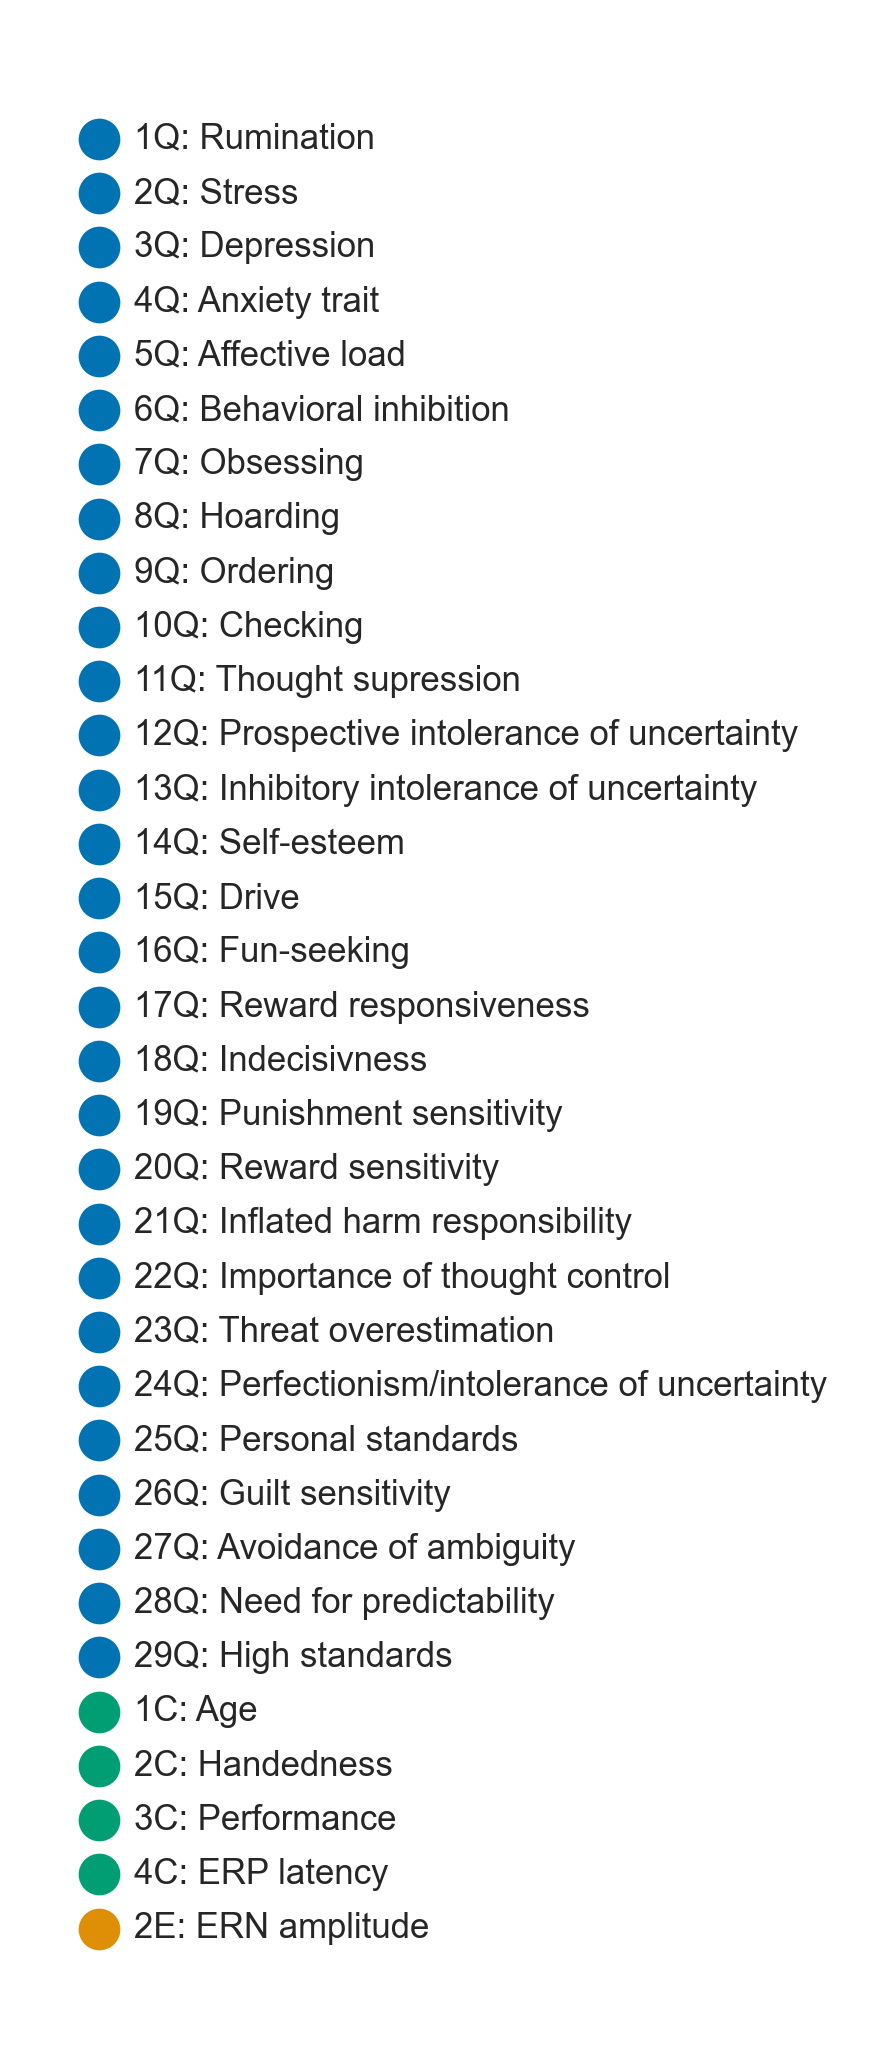

In [10]:
cm = 1/2.54
dpi = 500

plt.rcParams['figure.dpi'] = dpi
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['axes.labelsize'] = 6
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 0.5
sns.set_style("white")


palette = sns.color_palette("colorblind")

fig = plt.figure(3, figsize=(10*cm, 10*cm))
ax = fig.add_axes([0,0,1,1], aspect=1)
ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
# ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
    
# # change default range so that new circles will work
# ax.set_xlim((0, 10))
# ax.set_ylim((0, 10))
# some data
x = [0.5]*len(legend_labels)
y = np.linspace(0,1,len(legend_labels))

nodes_color=[palette[0] if item[1].find('Q') != -1 
                else palette[1]if item[1].find('E') != -1 
                else palette[2] for item in legend_labels.items()]


    
# ax.plot(x, y, 'o', color=nodes_color,  markersize=4)

for i, item in enumerate(legend_labels.items()):
    item_index = len(legend_labels) - i - 1
    
    ax.plot(
        x[item_index],
        y[item_index], 
        'o', 
        markersize=5,
        color=nodes_color[i],
    )
    
    plt.annotate(
        item[0],                       # label text
        (x[item_index], y[item_index]),                    # (x, y)
        textcoords="offset points",   
        xytext=(5, -1.35),               # (x, y) offset amount
        ha='left',
        fontsize=5
    )
    
plt.show()

fig.savefig('../images/diff_legend.png')